In [67]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import ttest_ind, chi2
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from scipy.stats import ttest_ind, chi2_contingency

In [68]:
data = pd.read_excel("df_total.xlsx")

In [69]:
# 去掉8和999
# 轉成字串並去除空白
data['Part_nbr'] = data['Part_nbr'].astype(str).str.strip()

# 建立條件
mask = data['Part_nbr'].str.startswith('8') | data['Part_nbr'].str.startswith('999')

# 過濾資料
data = data.loc[~mask].copy()

# # 驗證
# print("原始數量:", len(data))
# print("過濾後數量:", len(data1))

# # 檢查是否還有 '8' 或 '999' 開頭的
# print(data[data1['Part_nbr'].str.startswith('8')])
# print(data[data1['Part_nbr'].str.startswith('999')])


In [70]:
data.columns

Index(['Part_nbr', 'Lot_nbr', 'Layer', 'd_Layer', 'CamX', 'CamY', 'AVGX',
       'AVGY', 'Credate', 'MacNo', 'MacRecipe', 'mtl_desc1', 'mtl_desc2',
       'mtl_desc4', 'vend_nbr', 'layer_2Thick', 'plate_mtl_desc1',
       'plate_mtl_desc2', 'plate_vend_nbr', 'plate_layer_2Thick',
       'plate_RC_value', 'Residual Copper Rate', 'glass_fabric_thickness(mm)',
       'use_cu_upper_thickness', 'use_cu_lower_thickness', 'use_cu_type',
       'glass_fabric_type', 'parse_failed_desc', 'bake', 'bake_after_browning',
       'short', 'long', 'd_PSVarX', 'd_PSVarY', 'bake_result', 'bake_measured',
       'bake_after_browning_result', 'bake_after_browning_measured'],
      dtype='object')

<p style = "font_size: 16; color: blue;">欄位選擇</p>

In [71]:
data = data[['Part_nbr', 'Lot_nbr', 'Layer', 'd_Layer','AVGX','AVGY','MacNo', 'MacRecipe', 'mtl_desc2', 'mtl_desc4', 'vend_nbr',
         'layer_2Thick', 'plate_mtl_desc1', 'plate_mtl_desc2','plate_vend_nbr', 'plate_layer_2Thick', 'plate_RC_value',
         'Residual Copper Rate', 'glass_fabric_thickness(mm)','use_cu_upper_thickness', 'use_cu_lower_thickness', 'use_cu_type',
         'glass_fabric_type', 'short', 'long','bake_result', 'bake_measured','bake_after_browning_result', 'bake_after_browning_measured',
         'd_PSVarX', 'd_PSVarY']]

data = data.copy()
data['layer_2Thick'] = data['layer_2Thick'].replace('None', np.nan).astype(float)
data['layer_2Thick'] = data['layer_2Thick'].astype('float')

data['plate_mtl_desc2'] = data['plate_mtl_desc2'].astype('float')

data['bake_result'] =data['bake_result'].astype('O')
data['bake_measured'] =data['bake_measured'].astype('O')
data['bake_after_browning_result'] =data['bake_after_browning_result'].astype('O')
data['bake_after_browning_measured'] =data['bake_after_browning_measured'].astype('O')

data['plate_layer_2Thick'] = pd.to_numeric(data['plate_layer_2Thick'], errors='coerce')
data = data.rename(columns={"glass_fabric_thickness(mm)": "glass_fabric_thickness_mm"})
data = data.rename(columns={"Residual Copper Rate": "Residual_Copper_Rate"})

<p style = "font_size: 16; color: red;">Full Data</p>

<p style = "font_size: 16; color: blue;">合併少數料號</p>

In [72]:
df = data

# 找出小於閾值的料號列表
part_counts = df['Part_nbr'].value_counts()

threshold = 30
below_threshold_parts = part_counts[part_counts < threshold].index.tolist()

print(f"小於 {threshold} 筆數據的料號共有 {len(below_threshold_parts)} 個：")
# print(below_threshold_parts)

小於 30 筆數據的料號共有 835 個：


In [73]:
# 計算各料號的觀測數
part_counts = df['Part_nbr'].value_counts()

threshold = 30
df['Part_nbr_grouped'] = np.where(df['Part_nbr'].map(part_counts) < threshold,   'OTHER', df['Part_nbr'])

# 按分位數合併（合併底部25%）
# quantile_threshold = part_counts.quantile(0.25)
# df['Part_nbr_grouped'] = np.where(df['Part_nbr'].map(part_counts) < quantile_threshold, 'OTHER', df['Part_nbr'])

<p style = "font_size: 16; color: blue;">Modeling 前處理</p>

<p style = "font_size: 14; color: green;">RC 處理</p>

In [74]:
# 以每個 lot的RC補NaN
l2_rc_map = (
    df[df['d_Layer'] == 'L2']
    .dropna(subset=['plate_RC_value'])
    .groupby('Lot_nbr')['plate_RC_value']
    .first()
)

first_rc_map = (
    df.dropna(subset=['plate_RC_value'])
    .groupby('Lot_nbr')['plate_RC_value']
    .first()
)

final_rc_map = l2_rc_map.combine_first(first_rc_map)

df['plate_RC_value'] = df['plate_RC_value'].fillna(df['Lot_nbr'].map(final_rc_map))

In [75]:
# 剩下的用整體中位數補
overall_median_rc = df['plate_RC_value'].median()

rc_missing_parts = df[df['plate_RC_value'].isna()].groupby('Part_nbr')['plate_RC_value'].count()

all_parts_count = df.groupby('Part_nbr')['plate_RC_value'].count()

rc_missing_parts_aligned = rc_missing_parts.reindex(all_parts_count.index, fill_value=0)

fully_missing_parts = all_parts_count[rc_missing_parts_aligned == all_parts_count].index

df.loc[df['Part_nbr'].isin(fully_missing_parts), 'plate_RC_value'] = overall_median_rc

<p style="font-size: 14px; color: blue;"> 找出遺失值數量(比例)</p>

In [76]:
features_with_na = [features for features in df.columns if df[features].isnull().sum() > 1]

for feature in features_with_na:
    print(feature, df[feature].isnull().sum(), 'missing values')

MacRecipe 154 missing values
mtl_desc4 782 missing values
layer_2Thick 4330 missing values
plate_layer_2Thick 24024 missing values
glass_fabric_thickness_mm 782 missing values
use_cu_upper_thickness 782 missing values
use_cu_lower_thickness 782 missing values
use_cu_type 1411 missing values
glass_fabric_type 1687 missing values
short 3365 missing values
long 3365 missing values


<p style="font-size: 14px; color: blue;">找出有遺失值的數值型特徵<p>

In [77]:
numerical_features = [feature for feature in df.columns if df[feature].dtypes!='O']

print('Number of features: ',len(numerical_features))

# df[numerical_features].head()

Number of features:  16


<p style="font-size: 14px; color: blue;">找出有遺失值的離散型特徵<p>

In [78]:
discrete_feature = [feature for feature in numerical_features if len(df[feature].unique())<25]
print('Discrete variables count: {}'.format(len(discrete_feature)))
discrete_feature 

Discrete variables count: 3


['MacNo', 'use_cu_upper_thickness', 'use_cu_lower_thickness']

<p style="font-size: 14px; color: blue;">找出有遺失值的類別型特徵<p>

In [79]:
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']
print(len(categorical_features))
print(categorical_features)

16
['Part_nbr', 'Lot_nbr', 'Layer', 'd_Layer', 'MacRecipe', 'mtl_desc4', 'vend_nbr', 'plate_mtl_desc1', 'plate_vend_nbr', 'use_cu_type', 'glass_fabric_type', 'bake_result', 'bake_measured', 'bake_after_browning_result', 'bake_after_browning_measured', 'Part_nbr_grouped']


In [80]:
for feature in categorical_features:
    print('The feature is {} and number of categories are {}'.format(feature, len(df[feature].unique())))

The feature is Part_nbr and number of categories are 1235
The feature is Lot_nbr and number of categories are 4206
The feature is Layer and number of categories are 17
The feature is d_Layer and number of categories are 40
The feature is MacRecipe and number of categories are 182
The feature is mtl_desc4 and number of categories are 62
The feature is vend_nbr and number of categories are 11
The feature is plate_mtl_desc1 and number of categories are 96
The feature is plate_vend_nbr and number of categories are 9
The feature is use_cu_type and number of categories are 32
The feature is glass_fabric_type and number of categories are 77
The feature is bake_result and number of categories are 2
The feature is bake_measured and number of categories are 2
The feature is bake_after_browning_result and number of categories are 2
The feature is bake_after_browning_measured and number of categories are 2
The feature is Part_nbr_grouped and number of categories are 401


<p style="font-size: 14px; color: blue;">處理離散型遺失值<p>

In [81]:
features_nan = [feature for feature in df.columns if df[feature].isnull().sum()>1 and df[feature].dtype=='O']

for feature in features_nan:
    print('{}: {} missing value'.format(feature, df[feature].isnull().sum()))

MacRecipe: 154 missing value
mtl_desc4: 782 missing value
use_cu_type: 1411 missing value
glass_fabric_type: 1687 missing value


In [82]:
#這裡是將有nan的data挑出來，把nan換成Missing 標籤，因為等等要編碼(encode)，它不能是nan
def replace_cat_feature(data, features_nan):
    data1 = data.copy()
    data1[features_nan]=data[features_nan].fillna('Missing')
    return data1

df = replace_cat_feature(df, features_nan)

#nan沒有了，變成了Missing 標籤，所以都是0
df[features_nan].isnull().sum()

MacRecipe            0
mtl_desc4            0
use_cu_type          0
glass_fabric_type    0
dtype: int64

<p style="font-size: 14px; color: blue;">處理數值型遺失值<p>

In [83]:
numerical_with_nan = [feature for feature in df.columns if df[feature].isnull().sum()>1 and df[feature].dtype!='O']

for feature in numerical_with_nan:
    print('{}: {} missing value'.format(feature, df[feature].isnull().sum()))

layer_2Thick: 4330 missing value
plate_layer_2Thick: 24024 missing value
glass_fabric_thickness_mm: 782 missing value
use_cu_upper_thickness: 782 missing value
use_cu_lower_thickness: 782 missing value
short: 3365 missing value
long: 3365 missing value


In [84]:
# 先對每個數值欄位進行分群中位數填補
for feature in numerical_with_nan:
    # 新增一欄標示缺失
    df[feature + '_nan'] = np.where(df[feature].isnull(), 1, 0)
    
    # 對每個 (Part_nbr, Lot_nbr) 群組算中位數來填補
    df[feature] = df.groupby(['Part_nbr', 'Lot_nbr'])[feature]\
                        .transform(lambda x: x.fillna(x.median()))

# 若還有 NaN，用整體中位數補
for feature in numerical_with_nan:
    df[feature] = df[feature].fillna(df[feature].median())


C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.

In [85]:
df[numerical_with_nan].isnull().sum()

layer_2Thick                 0
plate_layer_2Thick           0
glass_fabric_thickness_mm    0
use_cu_upper_thickness       0
use_cu_lower_thickness       0
short                        0
long                         0
dtype: int64

<p style="font-size: 14px; color: blue;">處理類別型遺失值<p>

In [86]:
categorical_feattures = [feature for feature in df.columns if df[feature].dtypes=='O' ]
categorical_feattures

['Part_nbr',
 'Lot_nbr',
 'Layer',
 'd_Layer',
 'MacRecipe',
 'mtl_desc4',
 'vend_nbr',
 'plate_mtl_desc1',
 'plate_vend_nbr',
 'use_cu_type',
 'glass_fabric_type',
 'bake_result',
 'bake_measured',
 'bake_after_browning_result',
 'bake_after_browning_measured',
 'Part_nbr_grouped']

In [87]:
# 你想保留的欄位（不處理的）
excluded_features = ['Part_nbr', 'Lot_nbr', 'Layer', 'd_Layer', 'Part_nbr_grouped']

# 建立一個新的列表，過濾掉 excluded_features
processed_categorical_features = [f for f in categorical_features if f not in excluded_features]

# rare category 合併
for feature in processed_categorical_features:
    temp = df.groupby(feature)['d_PSVarX'].count() / len(df)
    temp_df = temp[temp > 0.01].index
    df[feature] = np.where(df[feature].isin(temp_df), df[feature], 'rare cate')

# target mean encoding
for feature in processed_categorical_features:
    labels_ordered = df.groupby([feature])['d_PSVarX'].mean().sort_values().index
    labels_ordered = {k: i for i, k in enumerate(labels_ordered, 0)}
    df[feature] = df[feature].map(labels_ordered)

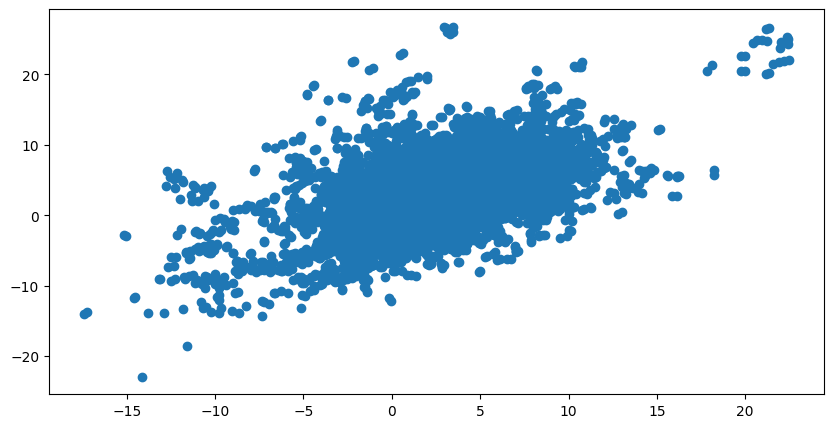

In [88]:
df = df[df['d_PSVarX'] < 4000]
df = df[df['d_PSVarY'] < 4000]
plt.figure(figsize=(10,5))
plt.scatter(df['d_PSVarX'],df['d_PSVarY'])

<p style="font-size: 14px; color: green;">拆分出異常資料<p>

In [89]:
target = 'd_PSVarX'
group_cols = ['Part_nbr', 'Lot_nbr']   # 判定「同一批」用的欄位
group_for_mixed = 'Part_nbr_grouped'           # mixed model 的 groups

df_unfiltered = df

# 使用 group_cols 當作 batch key
df_unfiltered['_batch_key'] = df_unfiltered[group_cols].astype(str).agg('__'.join, axis=1)

batch_stats = df_unfiltered.groupby('_batch_key')[target].agg(['count', 'mean', 'min', 'max']).reset_index()
batch_stats['range'] = batch_stats['max'] - batch_stats['min']

# 規則： range <= 3 且 mean in [0,5] -> normal
batch_stats['is_normal'] = (batch_stats['range'] <= 3) & (batch_stats['mean'] >= 0) & (batch_stats['mean'] <= 5)

# map 回原始 df
batch_flag = batch_stats.set_index('_batch_key')['is_normal'].to_dict()
df_unfiltered['batch_is_normal'] = df_unfiltered['_batch_key'].map(batch_flag)

# 切出 filtered df（只保留正常批）
df_filtered = df_unfiltered[df_unfiltered['batch_is_normal']].copy()
print("原始資料筆數:", len(df_unfiltered), "正常批資料筆數:", len(df_filtered))
print("總批數:", batch_stats.shape[0], "正常批數:", batch_stats['is_normal'].sum())

原始資料筆數: 55017 正常批資料筆數: 30069
總批數: 4205 正常批數: 2523


<p style="font-size: 14px; color: green;">對異常部分的data做GMM<p>

In [90]:
# df_outlier = df_unfiltered[~df_unfiltered['batch_is_normal']].copy()

In [91]:
# # # 標準化
# # features = ['MacNo','MacRecipe', 'mtl_desc2', 'vend_nbr', 'layer_2Thick', 'plate_mtl_desc1',
# #             'plate_mtl_desc2', 'plate_vend_nbr', 'plate_layer_2Thick',
# #             'plate_RC_value', 'Residual_Copper_Rate', 'glass_fabric_thickness_mm',
# #             'use_cu_upper_thickness', 'use_cu_lower_thickness', 'use_cu_type',
# #             'glass_fabric_type']

# # scaler = StandardScaler()
# # X_scaled = scaler.fit_transform(df_outlier[features])

# # # 用 BIC 選最佳群數
# # bic_scores = []
# # n_components_range = range(2, 10)  # 群數範圍
# # for n in n_components_range:
# #     gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
# #     gmm.fit(X_scaled)
# #     bic_scores.append(gmm.bic(X_scaled))

# # best_n = n_components_range[np.argmin(bic_scores)]
# # print(f"num of best clusters: {best_n}")

# # # 畫 BIC 曲線
# # plt.figure(figsize=(10,5))
# # plt.plot(n_components_range, bic_scores, marker='o')
# # plt.xlabel('num of clusters')
# # plt.ylabel('BIC')
# # plt.title('num of best clusters by BIC')
# # plt.show()

# # # 用最佳群數建立 GMM
# # gmm_best = GaussianMixture(n_components=best_n, covariance_type='full', random_state=123)
# # labels = gmm_best.fit_predict(X_scaled)
# # df_outlier['cluster'] = labels

# # # # 用 PCA 降成 2D 繪圖（可視化）
# # # pca = PCA(n_components=2)
# # # X_pca = pca.fit_transform(X_scaled)
# # # df_plot = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
# # # df_plot['cluster'] = labels

# # # plt.figure(figsize=(8,6))
# # # sns.scatterplot(data=df_plot, x='PC1', y='PC2', hue='cluster', palette='Set2')
# # # plt.title('GMM 分群結果 (PCA 2D 投影)')
# # # plt.show()

# # # 檢視各群特徵平均
# # cluster_means = df_outlier.groupby('cluster')[features].mean()
# # print(cluster_means)

# process_cols = ['Part_nbr']

# feature_cols = ["mtl_desc2", "layer_2Thick", "plate_layer_2Thick", "plate_RC_value", "Residual_Copper_Rate", "glass_fabric_thickness_mm", 
#                 "use_cu_upper_thickness", "short", "use_cu_lower_thickness"]

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(df_outlier[feature_cols])

# # # # 用 BIC 選最佳群數
# # bic_scores = []
# # n_components_range = range(2, 10)  # 群數範圍
# # for n in n_components_range:
# #     gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=123)
# #     gmm.fit(X_scaled)
# #     bic_scores.append(gmm.bic(X_scaled))

# # best_n = n_components_range[np.argmin(bic_scores)]
# # print(f"num of best clusters: {best_n}")

# # # 畫 BIC 曲線
# # plt.figure(figsize=(10,5))
# # plt.plot(n_components_range, bic_scores, marker='o')
# # plt.xlabel('num of clusters')
# # plt.ylabel('BIC')
# # plt.title('num of best clusters by BIC')
# # plt.show()


# def detect_anomalies(group, features, n_components):
#     # 標準化
#     X_scaled = StandardScaler().fit_transform(group[features].values)
    
#     # GMM
#     gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=123)
#     labels = gmm.fit_predict(X_scaled)

#     # 找異常 cluster
#     counts = pd.Series(labels).value_counts()
#     anomaly_label = counts.idxmin()

#     # 標註
#     group_result = group.copy()
#     group_result["is_anomaly"] = (labels == anomaly_label).astype(int)

#     # 差異分析
#     normal_data = group_result[group_result["is_anomaly"] == 0][features]
#     anomaly_data = group_result[group_result["is_anomaly"] == 1][features]
#     diff = anomaly_data.mean() - normal_data.mean()
    
#     return group_result, diff

# # 全資料找最佳群數
# scaler = StandardScaler()
# X_scaled_all = scaler.fit_transform(df_outlier[feature_cols])
# bic_scores = []
# n_components_range = range(2, 10)
# for n in n_components_range:
#     gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=123)
#     gmm.fit(X_scaled_all)
#     bic_scores.append(gmm.bic(X_scaled_all))

# best_n = n_components_range[np.argmin(bic_scores)]
# print(f"Best number of clusters (global): {best_n}")

# # 分組偵測
# results = []
# for cond, group in df_outlier.groupby(process_cols):
#     if len(group) < 40:
#         continue
#     group_res, diff = detect_anomalies(group, feature_cols, best_n)
#     results.append({
#         "process_condition": cond,
#         "sample_size": len(group),
#         "anomaly_ratio": group_res["is_anomaly"].mean(),
#         "top_features": diff.abs().sort_values(ascending=False).head(3).to_dict()
#     })

# summary_df = pd.DataFrame(results).sort_values(by="anomaly_ratio", ascending=False)
# print(summary_df)

# # print("\n=== 各製程條件異常與正常差異最大的特徵 ===")
# # for row in feature_diff_results:
# #     print(f"{row['process_condition']}: {row['feature_differences']}")

In [92]:
group_counts = df.groupby('Part_nbr').size().reset_index(name='count')
big_groups = group_counts[group_counts['count'] >= 40]['Part_nbr']
df_big = df[df['Part_nbr'].isin(big_groups)]

In [93]:
# import pandas as pd
# from scipy.stats import chi2_contingency, ttest_ind
# import numpy as np
# from statsmodels.stats.multitest import multipletests

# categorical_features = [
#     'MacNo','MacRecipe', 'mtl_desc2', 'vend_nbr', 'plate_mtl_desc1',
#     'plate_mtl_desc2', 'plate_vend_nbr', 'use_cu_type', 'glass_fabric_type'
# ]
# numeric_features = [
#     'layer_2Thick', 'plate_layer_2Thick', 'plate_RC_value',
#     'Residual_Copper_Rate', 'glass_fabric_thickness_mm',
#     'use_cu_upper_thickness', 'use_cu_lower_thickness'
# ]

# results = []

# # 計算 pooled std 用的函數
# def pooled_std(x1, x2):
#     n1, n2 = len(x1), len(x2)
#     var1, var2 = np.var(x1, ddof=1), np.var(x2, ddof=1)
#     return np.sqrt(((n1 -1)*var1 + (n2 -1)*var2) / (n1 + n2 - 2))

# # 類別變數 → 卡方檢定 + Cramér's V
# for col in categorical_features:
#     contingency_table = pd.crosstab(df_big[col].astype('category'),
#                                     df_big['batch_is_normal'])
#     chi2, p, dof, expected = chi2_contingency(contingency_table)
#     n = contingency_table.sum().sum()
#     k = min(contingency_table.shape)  # 取行或列數中較小的
#     cramers_v = np.sqrt(chi2 / (n * (k - 1))) if k > 1 else np.nan
#     results.append([col, 'categorical', chi2, p, cramers_v, np.nan])  # Cohen's d 不適用

# # 數值變數 → t-test + Cohen's d
# for col in numeric_features:
#     abnormal_vals = df_big[df_big['batch_is_normal'] == 0][col].dropna()
#     normal_vals = df_big[df_big['batch_is_normal'] == 1][col].dropna()
#     stat, p = ttest_ind(abnormal_vals, normal_vals, equal_var=False)
#     # 計算 Cohen's d
#     s_pooled = pooled_std(abnormal_vals, normal_vals)
#     cohen_d = (abnormal_vals.mean() - normal_vals.mean()) / s_pooled if s_pooled > 0 else np.nan
#     results.append([col, 'numeric', stat, p, np.nan, cohen_d])

# diff_df = pd.DataFrame(results, columns=['feature', 'type', 'statistic', 'p_value', "cramers_v", "cohen_d"])
# diff_df = diff_df.sort_values('p_value')

# diff_df['p_adj'] = multipletests(diff_df['p_value'], method='fdr_bh')[1]

# print(diff_df)


In [94]:
# multipletests?

In [95]:
# diff_df

<p style = "font_size: 16; color: red;">Filter Data</p>

<p style="font-size: 14px; color: green;">以批號判定正常 / 異常<p>

In [96]:
df_unfiltered = data

# 使用 group_cols 當作 batch key
df_unfiltered['_batch_key'] = df_unfiltered[group_cols].astype(str).agg('__'.join, axis=1)

batch_stats = df_unfiltered.groupby('_batch_key')[target].agg(['count', 'mean', 'min', 'max']).reset_index()
batch_stats['range'] = batch_stats['max'] - batch_stats['min']

# 規則： range <= 3 且 mean in [0,5] -> normal
batch_stats['is_normal'] = (batch_stats['range'] <= 3) & (batch_stats['mean'] >= 0) & (batch_stats['mean'] <= 5)

# map 回原始 df
batch_flag = batch_stats.set_index('_batch_key')['is_normal'].to_dict()
df_unfiltered['batch_is_normal'] = df_unfiltered['_batch_key'].map(batch_flag)

# 切出 filtered df（只保留正常批）
df_filtered = df_unfiltered[df_unfiltered['batch_is_normal']].copy()
print("原始資料筆數:", len(df), "正常批資料筆數:", len(df_filtered))
print("總批數:", batch_stats.shape[0], "正常批數:", batch_stats['is_normal'].sum())

# 列出不正常的 batch（供檢查）
abnormal_batches = batch_stats[~batch_stats['is_normal']].sort_values(['range','mean'], ascending=[False, True])
abnormal_batches.head(30).to_csv('abnormal_batches_top30.csv', index=False)
# print("已輸出 abnormal_batches_top30.csv (供檢查)")

原始資料筆數: 55017 正常批資料筆數: 30069
總批數: 4206 正常批數: 2523


In [97]:
# 正常批 少量的料號合併
part_counts = df_filtered['Part_nbr'].value_counts()

threshold = 30
df_filtered['Part_nbr_grouped'] = np.where(df_filtered['Part_nbr'].map(part_counts) < threshold,   'OTHER', df_filtered['Part_nbr'])

<p style = "font_size: 14; color: green;">RC 處理</p>

In [98]:
# 以每個 lot的RC補NaN
l2_rc_map = (
    df_filtered[df_filtered['d_Layer'] == 'L2']
    .dropna(subset=['plate_RC_value'])
    .groupby('Lot_nbr')['plate_RC_value']
    .first()
)

first_rc_map = (
    df_filtered.dropna(subset=['plate_RC_value'])
    .groupby('Lot_nbr')['plate_RC_value']
    .first()
)

final_rc_map = l2_rc_map.combine_first(first_rc_map)

df_filtered['plate_RC_value'] =df_filtered['plate_RC_value'].fillna(df['Lot_nbr'].map(final_rc_map))

In [99]:
# 剩下的用整體中位數補
overall_median_rc = df_filtered['plate_RC_value'].median()

rc_missing_parts = df_filtered[df_filtered['plate_RC_value'].isna()].groupby('Part_nbr')['plate_RC_value'].count()

all_parts_count = df_filtered.groupby('Part_nbr')['plate_RC_value'].count()

rc_missing_parts_aligned = rc_missing_parts.reindex(all_parts_count.index, fill_value=0)

fully_missing_parts = all_parts_count[rc_missing_parts_aligned == all_parts_count].index

df_filtered.loc[df_filtered['Part_nbr'].isin(fully_missing_parts), 'plate_RC_value'] = overall_median_rc

<p style="font-size: 14px; color: blue;"> 找出遺失值數量(比例)</p>

In [100]:
features_with_na = [features for features in df_filtered.columns if df_filtered[features].isnull().sum() > 1]

for feature in features_with_na:
    print(feature, df_filtered[feature].isnull().sum(), 'missing values')

MacRecipe 80 missing values
mtl_desc4 304 missing values
layer_2Thick 2626 missing values
plate_layer_2Thick 13238 missing values
glass_fabric_thickness_mm 304 missing values
use_cu_upper_thickness 304 missing values
use_cu_lower_thickness 304 missing values
use_cu_type 624 missing values
glass_fabric_type 768 missing values
short 1612 missing values
long 1612 missing values


<p style="font-size: 14px; color: blue;">找出有遺失值的數值型特徵<p>

In [101]:
numerical_features = [feature for feature in df_filtered.columns if df_filtered[feature].dtypes!='O']

print('Number of features: ',len(numerical_features))

# df[numerical_features].head()

Number of features:  17


<p style="font-size: 14px; color: blue;">找出有遺失值的離散型特徵<p>

In [102]:
discrete_feature = [feature for feature in numerical_features if len(df_filtered[feature].unique())<25]
print('Discrete variables count: {}'.format(len(discrete_feature)))
discrete_feature 

Discrete variables count: 4


['MacNo',
 'use_cu_upper_thickness',
 'use_cu_lower_thickness',
 'batch_is_normal']

<p style="font-size: 14px; color: blue;">找出有遺失值的類別型特徵<p>

In [103]:
categorical_features = [feature for feature in df_filtered.columns if df_filtered[feature].dtype == 'O']
print(len(categorical_features))
print(categorical_features)

17
['Part_nbr', 'Lot_nbr', 'Layer', 'd_Layer', 'MacRecipe', 'mtl_desc4', 'vend_nbr', 'plate_mtl_desc1', 'plate_vend_nbr', 'use_cu_type', 'glass_fabric_type', 'bake_result', 'bake_measured', 'bake_after_browning_result', 'bake_after_browning_measured', 'Part_nbr_grouped', '_batch_key']


In [104]:
for feature in categorical_features:
    print('The feature is {} and number of categories are {}'.format(feature, len(df_filtered[feature].unique())))

The feature is Part_nbr and number of categories are 995
The feature is Lot_nbr and number of categories are 2523
The feature is Layer and number of categories are 16
The feature is d_Layer and number of categories are 40
The feature is MacRecipe and number of categories are 150
The feature is mtl_desc4 and number of categories are 58
The feature is vend_nbr and number of categories are 11
The feature is plate_mtl_desc1 and number of categories are 90
The feature is plate_vend_nbr and number of categories are 9
The feature is use_cu_type and number of categories are 30
The feature is glass_fabric_type and number of categories are 72
The feature is bake_result and number of categories are 2
The feature is bake_measured and number of categories are 2
The feature is bake_after_browning_result and number of categories are 2
The feature is bake_after_browning_measured and number of categories are 2
The feature is Part_nbr_grouped and number of categories are 203
The feature is _batch_key an

<p style="font-size: 14px; color: blue;">處理離散型遺失值<p>

In [105]:
features_nan = [feature for feature in df_filtered.columns if df_filtered[feature].isnull().sum()>1 and df_filtered[feature].dtype=='O']

for feature in features_nan:
    print('{}: {} missing value'.format(feature, df_filtered[feature].isnull().sum()))

MacRecipe: 80 missing value
mtl_desc4: 304 missing value
use_cu_type: 624 missing value
glass_fabric_type: 768 missing value


In [106]:
#這裡是將有nan的data挑出來，把nan換成Missing 標籤，因為等等要編碼(encode)，它不能是nan
def replace_cat_feature(data, features_nan):
    data1 = data.copy()
    data1[features_nan]=data[features_nan].fillna('Missing')
    return data1

df_filtered = replace_cat_feature(df_filtered, features_nan)

#nan沒有了，變成了Missing 標籤，所以都是0
df_filtered[features_nan].isnull().sum()

MacRecipe            0
mtl_desc4            0
use_cu_type          0
glass_fabric_type    0
dtype: int64

<p style="font-size: 14px; color: blue;">處理數值型遺失值<p>

In [107]:
numerical_with_nan = [feature for feature in df_filtered.columns if df_filtered[feature].isnull().sum()>1 and df_filtered[feature].dtype!='O']

for feature in numerical_with_nan:
    print('{}: {} missing value'.format(feature, df_filtered[feature].isnull().sum()))

layer_2Thick: 2626 missing value
plate_layer_2Thick: 13238 missing value
glass_fabric_thickness_mm: 304 missing value
use_cu_upper_thickness: 304 missing value
use_cu_lower_thickness: 304 missing value
short: 1612 missing value
long: 1612 missing value


In [108]:
# 先對每個數值欄位進行分群中位數填補
for feature in numerical_with_nan:
    # 新增一欄標示缺失
    df_filtered[feature + '_nan'] = np.where(df_filtered[feature].isnull(), 1, 0)
    
    # 對每個 (Part_nbr, Lot_nbr) 群組算中位數來填補
    df_filtered[feature] = df_filtered.groupby(['Part_nbr', 'Lot_nbr'])[feature]\
                             .transform(lambda x: x.fillna(x.median()))


C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.

In [109]:
print('numbers of NaN in the all lot with df_filtered: \n')
for feature in numerical_with_nan:
    print('{}: {}'.format(feature, df_filtered[feature].isnull().sum()))

numbers of NaN in the all lot with df_filtered: 

layer_2Thick: 2626
plate_layer_2Thick: 2626
glass_fabric_thickness_mm: 0
use_cu_upper_thickness: 0
use_cu_lower_thickness: 0
short: 1454
long: 1454


In [110]:
# 若還有 NaN，用整體中位數補
for feature in numerical_with_nan:
    df_filtered[feature] = df_filtered[feature].fillna(df_filtered[feature].median())


In [111]:
df_filtered[numerical_with_nan].isnull().sum()

layer_2Thick                 0
plate_layer_2Thick           0
glass_fabric_thickness_mm    0
use_cu_upper_thickness       0
use_cu_lower_thickness       0
short                        0
long                         0
dtype: int64

<p style="font-size: 14px; color: blue;">處理類別型遺失值<p>

In [112]:
categorical_feattures = [feature for feature in df_filtered.columns if df_filtered[feature].dtypes=='O' ]
categorical_feattures

['Part_nbr',
 'Lot_nbr',
 'Layer',
 'd_Layer',
 'MacRecipe',
 'mtl_desc4',
 'vend_nbr',
 'plate_mtl_desc1',
 'plate_vend_nbr',
 'use_cu_type',
 'glass_fabric_type',
 'bake_result',
 'bake_measured',
 'bake_after_browning_result',
 'bake_after_browning_measured',
 'Part_nbr_grouped',
 '_batch_key']

In [113]:
# 你想保留的欄位（不處理的）
excluded_features = ['Part_nbr', 'Lot_nbr', 'Layer', 'd_Layer', 'Part_nbr_grouped']

# 建立一個新的列表，過濾掉 excluded_features
processed_categorical_features = [f for f in categorical_features if f not in excluded_features]

# rare category 合併
for feature in processed_categorical_features:
    temp = df_filtered.groupby(feature)['d_PSVarX'].count() / len(df_filtered)
    temp_df = temp[temp > 0.01].index
    df_filtered[feature] = np.where(df_filtered[feature].isin(temp_df), df_filtered[feature], 'rare cate')

# target mean encoding
for feature in processed_categorical_features:
    labels_ordered = df_filtered.groupby([feature])['d_PSVarX'].mean().sort_values().index
    labels_ordered = {k: i for i, k in enumerate(labels_ordered, 0)}
    df_filtered[feature] = df_filtered[feature].map(labels_ordered)

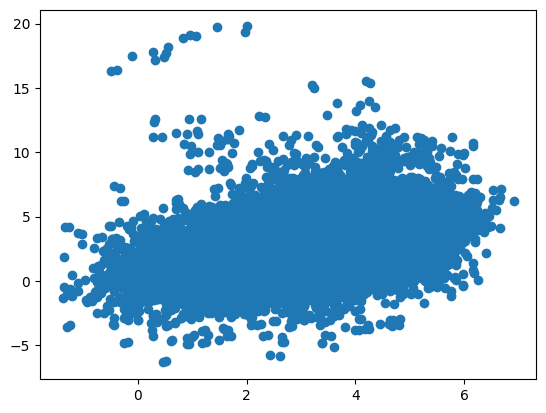

In [114]:
plt.scatter(df_filtered['d_PSVarX'],df_filtered['d_PSVarY'])

In [115]:
# df_filtered.columns
# df_filtered[df_filtered['Part_nbr_grouped']=='OTHER']

In [116]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.datasets import make_classification

# X = df_filtered[['MacNo',
#        'MacRecipe', 'mtl_desc2', 'vend_nbr', 'layer_2Thick', 'plate_mtl_desc1',
#        'plate_mtl_desc2', 'plate_vend_nbr', 'plate_layer_2Thick',
#        'plate_RC_value', 'Residual_Copper_Rate', 'glass_fabric_thickness_mm',
#        'use_cu_upper_thickness', 'use_cu_lower_thickness', 'use_cu_type',
#        'glass_fabric_type', 'short', 'bake_result', 'bake_after_browning_result']]

# Y = df_filtered[['d_PSVarX']]

# rf_reg_mod = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=3) #解包字典
# rf_reg_mod.fit(X, Y)

# print('R_square: ',rf_reg_mod.score(X, Y))


In [117]:
# rf_feature_importances = rf_reg_mod.feature_importances_

# feature_importances_df = pd.DataFrame({'features': X.columns,
#                                       'feature_importances':rf_feature_importances
#                                      })

# feature_importances_df = feature_importances_df.sort_values(by = 'feature_importances', ascending = False).reset_index(drop=True)
# feature_importances_df

In [118]:
# 你想保留的欄位（不處理的）
excluded_features = ['Part_nbr', 'Lot_nbr', 'Layer', 'd_Layer', 'Part_nbr_grouped']

# 建立一個新的列表，過濾掉 excluded_features
processed_categorical_features = [f for f in categorical_features if f not in excluded_features]

# rare category 合併
for feature in processed_categorical_features:
    temp = df_filtered.groupby(feature)['d_PSVarX'].count() / len(df)
    temp_df = temp[temp > 0.01].index
    df_filtered[feature] = np.where(df_filtered[feature].isin(temp_df), df_filtered[feature], 'rare cate')

# target mean encoding
for feature in processed_categorical_features:
    labels_ordered = df_filtered.groupby([feature])['d_PSVarX'].mean().sort_values().index
    labels_ordered = {k: i for i, k in enumerate(labels_ordered, 0)}
    df_filtered[feature] = df_filtered[feature].map(labels_ordered)

In [119]:
# import pandas as pd
# from sklearn.mixture import GaussianMixture
# from sklearn.preprocessing import StandardScaler

# # 假設你的 DataFrame 名為 df
# # 製程條件欄位（先換成你的實際欄位名稱）
# process_cols = ['Part_nbr']

# # 你要用來判斷異常的數值型特徵（可以放多個）
# feature_cols = ["mtl_desc2", "layer_2Thick", "plate_layer_2Thick", "plate_RC_value", "Residual_Copper_Rate", "glass_fabric_thickness_mm", 
#                 "use_cu_upper_thickness", "short", "use_cu_lower_thickness"]

# # 存結果
# results = []

# # 逐製程條件分組
# for cond, group in df.groupby(process_cols):
#     if len(group) < 5:
#         continue  # 太小的群跳過，避免 GMM 不穩

#     # 標準化
#     X = group[feature_cols].values
#     X_scaled = StandardScaler().fit_transform(X)

#     # GMM 假設分兩類（一類正常，一類異常）
#     gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=123)
#     labels = gmm.fit_predict(X_scaled)

#     # 判斷哪個 cluster 是異常 → 用 cluster 的樣本數少的那個
#     counts = pd.Series(labels).value_counts()
#     anomaly_label = counts.idxmin()

#     # 標註異常
#     group_result = group.copy()
#     group_result["is_anomaly"] = (labels == anomaly_label).astype(int)

#     # 統計異常比例
#     anomaly_ratio = group_result["is_anomaly"].mean()

#     results.append({
#         "process_condition": cond,
#         "sample_size": len(group),
#         "anomaly_ratio": anomaly_ratio
#     })

#     # 如果要保留每筆標註後的資料，可以另外存起來
#     # all_labeled_data.append(group_result)

# # 彙整統計表
# summary_df = pd.DataFrame(results)
# summary_df.sort_values(by="anomaly_ratio", ascending=False, inplace=True)

# print(summary_df)


<p style="font-size: 16px; color: blue;">Modeling<p>

<p style="font-size: 14px; color: green;">檢查欄位<p>

In [120]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# ---- 1. 定義要標準化的特徵 ----
feature_scale = [
    'mtl_desc2', 'layer_2Thick', 'plate_layer_2Thick', 'Residual_Copper_Rate', 
    'glass_fabric_thickness_mm', 'use_cu_upper_thickness', 
    'short', 'long', 'use_cu_lower_thickness'
]
################################### MinMax for the columns ##############################
# # 確保這些特徵存在於 df
# feature_scale = [feature for feature in feature_scale if feature in df.columns]

# # ---- 2. 標準化 ----
# scaler = MinMaxScaler()  # 也可以改成 StandardScaler()
# df_scaled = df.copy()
# df_filtered_scaled = df_filtered.copy()

# df_scaled[feature_scale] = scaler.fit_transform(df_scaled[feature_scale])
# df_filtered_scaled[feature_scale] = scaler.transform(df_filtered_scaled[feature_scale])
#########################################################################################
#################################### MinMax for the Part_nbr_grouped ####################
# 確保特徵存在
feature_scale = [feature for feature in feature_scale if feature in df.columns]

df_scaled = df.copy()
df_filtered_scaled = df_filtered.copy()

# ---- 以料號群組做 MinMax ----
for feat in feature_scale:
    df_scaled[feat] = df_scaled.groupby("Part_nbr_grouped")[feat].transform(
        lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 0
    )

    df_filtered_scaled[feat] = df_filtered_scaled.groupby("Part_nbr_grouped")[feat].transform(
        lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 0
    )
#########################################################################################
# # ---- 3. 對 target d_PSVarX 做 Shift + log1p ----
# target = 'd_PSVarX'

# # 找最小值
# shift = -df_scaled[target].min() + 1 if df_scaled[target].min() <= 0 else 0

# df_scaled[target + '_log'] = np.log1p(df_scaled[target] + shift)
# df_filtered_scaled[target + '_log'] = np.log1p(df_filtered_scaled[target] + shift)

# print(f"Shift value used for log transform: {shift}")

df_filtered = df_filtered_scaled
# df_filtered['d_PSVarX'] = df_filtered_scaled['d_PSVarX_log']
df = df_scaled
# df['d_PSVarX'] = df['d_PSVarX_log']

In [121]:
def rc_bucket(x):
    try:
        if pd.isna(x):
            return 'RC_NA'
        x = float(x)
    except Exception:
        return 'RC_NA'
    if x > 70:
        return '3'
    elif x > 60:
        return '2'
    else:
        return '1'

df['RC_level'] = df['plate_RC_value'].apply(rc_bucket)
df_filtered['RC_level'] = df_filtered['plate_RC_value'].apply(rc_bucket)

In [122]:
df = df.copy() 
target = 'd_PSVarX'
group_cols = ['Part_nbr', 'Lot_nbr']   # 判定「同一批」用的欄位
group_for_mixed = 'Part_nbr_grouped'           # mixed model 的 groups  plate_RC_value    C(RC_level)
formula = """
d_PSVarX ~ mtl_desc2 +  plate_layer_2Thick + 
           Residual_Copper_Rate + glass_fabric_thickness_mm + use_cu_upper_thickness + short + use_cu_lower_thickness +
           C(use_cu_type) + C(glass_fabric_type) + C(RC_level)  + C(vend_nbr) + C(mtl_desc4)
           """

# formula = """
# d_PSVarX ~ mtl_desc2 + layer_2Thick + plate_mtl_desc2 + plate_layer_2Thick + plate_RC_value +
#            Residual_Copper_Rate + glass_fabric_thickness_mm + use_cu_upper_thickness + short + use_cu_lower_thickness +
#            C(use_cu_type) + C(glass_fabric_type) + C(vend_nbr) + C(MacRecipe) + C(MacNo) + 
#            C(bake_result) + C(bake_after_browning_result)
#            """
vc = {
    "MacNo": "0 + C(MacNo)",
   "MacRecipe": "0 + C(MacRecipe)"
   # "Vend": "0 + C(vend_nbr)"
}
# -------------------------------------

# 檢查必要欄位存在
for c in group_cols + [target, group_for_mixed]:
    if c not in df.columns:
        raise ValueError(f"資料裡缺少欄位：{c}")

# 轉成數值
# df[target] = pd.to_numeric(df[target], errors='coerce')

In [123]:
df_filtered = df_filtered.copy() 
target = 'd_PSVarX'
group_cols = ['Part_nbr', 'Lot_nbr']   # 判定「同一批」用的欄位
group_for_mixed = 'Part_nbr_grouped'           # mixed model 的 groups  --C(vend_nbr) + C(MacRecipe) + C(MacNo) +
formula = """
d_PSVarX ~ mtl_desc2 +  plate_layer_2Thick + 
           Residual_Copper_Rate + glass_fabric_thickness_mm + use_cu_upper_thickness + short + use_cu_lower_thickness +
           C(use_cu_type) + C(glass_fabric_type) + C(RC_level) + C(vend_nbr) + C(mtl_desc4)
           
           """
vc = {
    "MacNo": "0 + C(MacNo)",
   "MacRecipe": "0 + C(MacRecipe)"
  # "Vend": "0 + C(vend_nbr)"
}
# -------------------------------------

# 檢查必要欄位存在
for c in group_cols + [target, group_for_mixed]:
    if c not in df.columns:
        raise ValueError(f"資料裡缺少欄位：{c}")

# 轉成數值
# df[target] = pd.to_numeric(df[target], errors='coerce')

In [124]:
# df_filtered.columns

In [125]:
# import statsmodels.formula.api as smf
# import patsy as pt

# target, formula = pt.dmatrices(formula, df, return_type="dataframe")
# rank = np.linalg.matrix_rank(formula.values)
# cond = np.linalg.cond(formula.values)
# print("X shape:", formula.shape, " rank:", rank, "  cond:", cond)

In [126]:
# df_filtered[group_for_mixed].value_counts().describe() # check極端小的group

<p style="font-size: 14px; color: green;">定義 fit + diagnostics 函式<p>

In [127]:
def fit_mixed_and_diagnostics(df_input, label):
    """
    Fit MixedLM with reml=False (for model comparison) and reml=True (final),
    return results dict and draw diagnostics.
    """
    part_counts = df_input['Part_nbr'].value_counts()
    
    # fit with ML (reml=False) for fair comparison via AIC/BIC/LLF if needed
    md_ml = smf.mixedlm(formula, df_input, groups=df_input[group_for_mixed], vc_formula=vc, re_formula="1") #  + Residual_Copper_Rate + glass_fabric_thickness_mm
    try:
        res_ml = md_ml.fit(reml=False, method='bfgs',  maxiter=2000)
    except Exception as e:
        print("[WARN] ML fit failed, try default method. Err:", e)
        res_ml = md_ml.fit(reml=False)
    
    # fit final with REML for better variance components
    md_reml = smf.mixedlm(formula, df_input, groups=df_input[group_for_mixed], vc_formula=vc, re_formula="1")
    try:
        res_reml = md_reml.fit(reml=True, method='bfgs', maxiter=2000)
    except Exception:
        res_reml = md_reml.fit(reml=True, method='bfgs')
    
    # diagnostics
    fitted = res_ml.fittedvalues   # use ML-fitted values for comparability
    resid = res_ml.resid

    random_effects = res_ml.random_effects  # 從 res_ml 取出隨機效應
    
    # fitted (只固定效應)
    fe_params = res_ml.fe_params.values
    X_fe = res_ml.model.exog
    y_hat_marg = X_fe @ fe_params

    # scale = res_ml.scale                      # 殘差變異
    # var_part = float(res_ml.cov_re.iloc[0,0]) # group(Part) 截距變異
    # ICC = var_part / (var_part + scale)
    # print(f"ICC (Part): {ICC:.3f}  |  Var(Part)={var_part:.3f},  Var(resid)={scale:.3f}")

    # # Part 截距變異（可能很小）
    # var_part = float(m.cov_re.iloc[0,0])
    # scale = m.scale

    # # 注意：vc 的變異不在 cov_re 裡，要另外從結果中的 vc names 讀
    # vc_vars = {k: float(v) for k, v in m.vcomp.items()}  # statsmodels 會回傳各 vc 成分估計
    # var_random_total = var_part + sum(vc_vars.values())

    # ICC_part = var_part / (var_part + scale) if (var_part + scale) > 0 else 0.0
    # ICC_total = var_random_total / (var_random_total + scale) if (var_random_total + scale) > 0 else 0.0

    # print("Var(Part)=", var_part, " Var(vc)=", vc_vars, " Var(resid)=", scale)
    # print(f"ICC_part={ICC_part:.3f} | ICC_total={ICC_total:.3f}")

    out = {
        'label': label,
        'res_ml': res_ml,
        'res_reml': res_reml,
        'fitted': fitted,
        'resid': resid,
        'random_effects': random_effects,
        'fe_params': fe_params,
        'X_fe': X_fe,
        'y_hat_marg': y_hat_marg
    }
    return out


In [128]:
# fit on full and filtered
print("開始 fit 全資料 (ML)... 這可能需要一段時間")
full_mod = fit_mixed_and_diagnostics(df, label='full')


開始 fit 全資料 (ML)... 這可能需要一段時間


In [129]:
print("開始 fit 過濾後資料 (ML)...")
filtered_mod = fit_mixed_and_diagnostics(df_filtered, label='filtered')

開始 fit 過濾後資料 (ML)...


<p style="font-size: 14px; color: green;">比較模型指標<p>

In [130]:
# filtered_mod['random_effects']

In [131]:
def print_compare(full, filtered):
    print("===== ML (reml=False) 比較 =====")
    print("Full:  llf=%.3f   AIC=%.3f   BIC=%.3f   nobs=%d" % (full['res_ml'].llf, full['res_ml'].aic, full['res_ml'].bic, full['res_ml'].nobs))
    print("Filt:  llf=%.3f   AIC=%.3f   BIC=%.3f   nobs=%d" % (filtered['res_ml'].llf, filtered['res_ml'].aic, filtered['res_ml'].bic, filtered['res_ml'].nobs))
    print("\n===== REML (final estimates) 摘要 (filtered) =====")
    print(full['res_reml'].summary())
    print(filtered['res_reml'].summary())
    
print_compare(full_mod, filtered_mod)

===== ML (reml=False) 比較 =====
Full:  llf=-110040.377   AIC=220204.754   BIC=220757.509   nobs=55017
Filt:  llf=-44043.710   AIC=88189.420   BIC=88613.294   nobs=30069

===== REML (final estimates) 摘要 (filtered) =====
                Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    d_PSVarX    
No. Observations:      55017      Method:                REML        
No. Groups:            401        Scale:                 2.9644      
Min. group size:       30         Log-Likelihood:        -110136.3210
Max. group size:       11493      Converged:             Yes         
Mean group size:       137.2                                         
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   2.686    0.635  4.232 0.000  1.442  3.930
C(use_cu_type)[T.1]        -

In [136]:
import statsmodels.formula.api as smf

group_for_mixed = 'Part_nbr_grouped'           # mixed model 的 groups
formula = """
d_PSVarX ~ mtl_desc2 +  plate_layer_2Thick + 
           Residual_Copper_Rate + glass_fabric_thickness_mm + use_cu_upper_thickness + short + use_cu_lower_thickness +
           C(use_cu_type) + C(glass_fabric_type) + C(RC_level) + C(vend_nbr) + C(mtl_desc4)
           """


n_boot = 200
coef_results = []

for i in range(n_boot):
    # bootstrap by group
    boot_df = df_filtered.groupby(group_for_mixed, group_keys=False)\
                         .apply(lambda x: x.sample(frac=1, replace=True))
    try:
        # boot_model = smf.mixedlm(formula, boot_df, groups=boot_df[group_for_mixed])
        boot_model = smf.mixedlm(formula, boot_df, groups=boot_df[group_for_mixed], re_formula="1")
        boot_result = boot_model.fit(reml=True, method='bfgs', maxiter=2000)
        coef_results.append(boot_result.params)
    except Exception as e:
        print(f"Bootstrap {i} failed: {e}")

# 匯總結果
coef_df = pd.DataFrame(coef_results)

summary_df = pd.DataFrame({
    "mean": coef_df.mean(),
    "std": coef_df.std(),
    "2.5%": coef_df.quantile(0.025),
    "97.5%": coef_df.quantile(0.975)
})

print(summary_df)



C:\Users\wilson_liu\AppData\Local\Temp\ipykernel_11336\3705102888.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=1, replace=True))
C:\Users\wilson_liu\AppData\Local\Temp\ipykernel_11336\3705102888.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=1, replace=True))
C:\Users\wilson_liu\AppData\Local\Temp\ipykernel_11336\3705102888.py:17: FutureWarni

                                mean       std      2.5%     97.5%
Intercept                   2.641579  0.182347  2.301594  3.043380
C(use_cu_type)[T.1]        -0.245985  0.118380 -0.467291 -0.027293
C(use_cu_type)[T.2]        -0.033382  0.112809 -0.283776  0.195754
C(use_cu_type)[T.3]        -0.033988  0.112813 -0.249422  0.204266
C(use_cu_type)[T.4]         0.021409  0.110666 -0.219774  0.240808
C(use_cu_type)[T.5]        -0.127380  0.113359 -0.380782  0.093835
C(use_cu_type)[T.6]         0.140212  0.104942 -0.063059  0.339487
C(use_cu_type)[T.7]         0.181575  0.112479 -0.053414  0.393810
C(use_cu_type)[T.8]         0.510894  0.143332  0.222246  0.782722
C(use_cu_type)[T.9]         0.063960  0.111040 -0.158314  0.267034
C(glass_fabric_type)[T.1]   0.128234  0.081448 -0.020546  0.286091
C(glass_fabric_type)[T.2]  -0.026515  0.116256 -0.255757  0.182653
C(glass_fabric_type)[T.3]   0.133007  0.086021 -0.025858  0.298442
C(glass_fabric_type)[T.4]   0.145482  0.088873 -0.017561  0.31

In [ ]:
# coef_df.describe().to_excel('coef_df_BT500.xlsx', index=False)

In [ ]:
# LRT for df_filtered
#    use_cu_type: O
#    glass_fabric_type: O
#    vend_nbr: O
#    MacRecipe: O
#    MacNo: O
#    bake_result: x
#    bake_after_browning_result: X

formula1 = """
d_PSVarX ~ mtl_desc2 + layer_2Thick + plate_mtl_desc2 + plate_layer_2Thick + C(RC_level) +
           Residual_Copper_Rate + glass_fabric_thickness_mm + use_cu_upper_thickness + short + use_cu_lower_thickness +
           C(use_cu_type) + C(glass_fabric_type) + C(vend_nbr) 

           """
full = smf.mixedlm(formula1, df_filtered, groups=df_filtered[group_for_mixed], re_formula="1").fit(reml=False, method='bfgs', maxiter=2000)

formula2 = """
d_PSVarX ~ mtl_desc2 + layer_2Thick + plate_mtl_desc2 + plate_layer_2Thick + 
           Residual_Copper_Rate + glass_fabric_thickness_mm + use_cu_upper_thickness + short + use_cu_lower_thickness +
           C(use_cu_type) + C(glass_fabric_type)

           """
reduced = smf.mixedlm(formula2, df_filtered, groups=df_filtered[group_for_mixed], re_formula="1").fit(reml=False, method='bfgs', maxiter=2000)

# df_diff = (len(full.params) - len(reduced.params))
df_diff = full.fe_params.size - reduced.fe_params.size   # 使用 fixed-effects 參數數量差

lr_stat = 2 * (full.llf - reduced.llf) 
p_value = chi2.sf(lr_stat, df=df_diff) 

print(f"Likelihood Ratio Test Results:")
print(f"LR Statistic: {lr_stat:.4f}")
print(f"Degrees of Freedom: {df_diff}")
print(f"p-value: {p_value:.4g}")

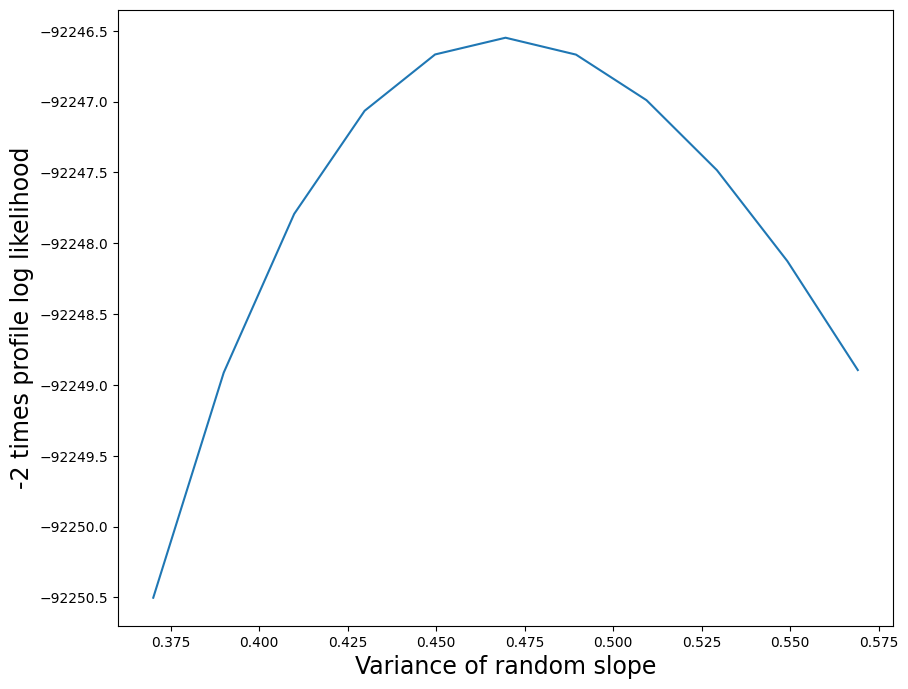

In [604]:
md_reml = smf.mixedlm(formula, df_filtered, groups=df_filtered[group_for_mixed], re_formula="1")
mdf = md_reml.fit()
re = mdf.cov_re

with warnings.catch_warnings():
    # Parameter is often on the boundary
    warnings.simplefilter("ignore")
    likev = mdf.profile_re(0, "re", dist_low=0.1 , dist_high=0.1)

plt.figure(figsize=(10, 8))
plt.plot(likev[:, 0], 2 * likev[:, 1])
plt.xlabel("Variance of random slope", size=17)
lbl = plt.ylabel("-2 times profile log likelihood", size=17)

<p style="font-size: 14px; color: green;">畫殘差診斷圖 (QQ + Fitted vs Residuals)<p>

Diagnostics: Full model


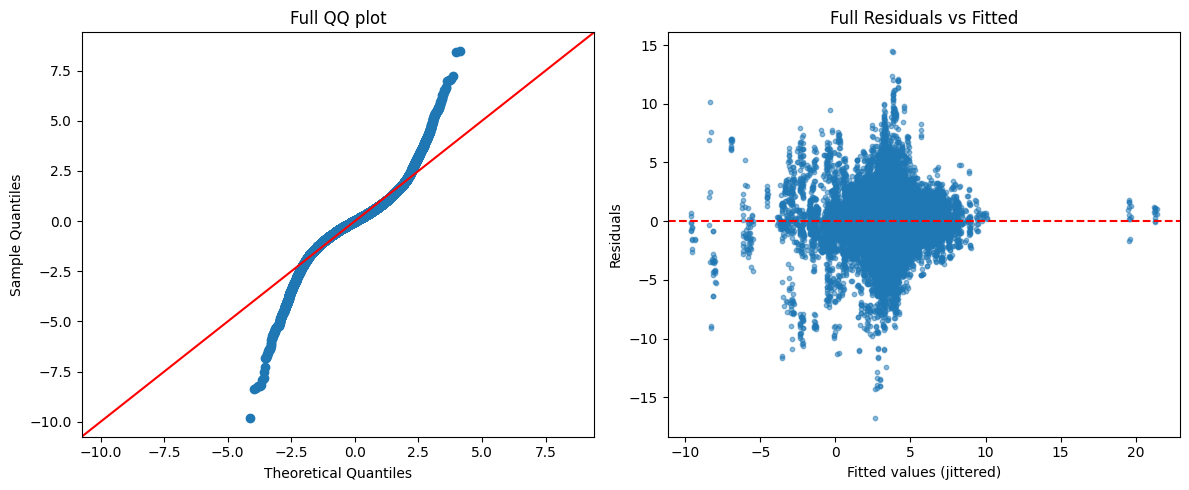

Diagnostics: Filtered model


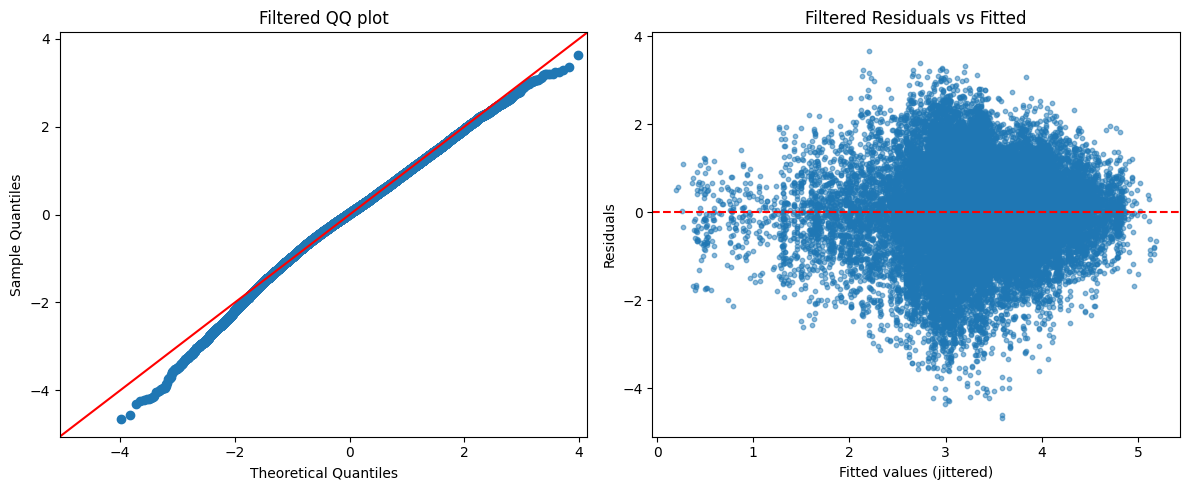

In [67]:
def plot_diagnostics(res_obj, fitted, resid, title_prefix):
    # 創建一個新的圖形，設置大小
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
    
    # 第一個子圖：QQ圖
    sm.qqplot(resid, line='45', fit=True, ax=ax1)
    ax1.set_title(f'{title_prefix} QQ plot')

    # 第二個子圖：殘差圖
    ax2.scatter(fitted + np.random.normal(0, 1e-6, size=len(fitted)), resid, alpha=0.5, s=10)
    ax2.axhline(0, color='red', linestyle='--')
    ax2.set_xlabel('Fitted values (jittered)')
    ax2.set_ylabel('Residuals')
    ax2.set_title(f'{title_prefix} Residuals vs Fitted')
    
    plt.tight_layout()
    plt.show()

print("Diagnostics: Full model")
plot_diagnostics(full_mod['res_ml'], full_mod['fitted'], full_mod['resid'], 'Full')

print("Diagnostics: Filtered model")
plot_diagnostics(filtered_mod['res_ml'], filtered_mod['fitted'], filtered_mod['resid'], 'Filtered')

In [68]:
durbin_watson(filtered_mod['resid']) # 獨立ok

np.float64(0.5710014506325544)

In [69]:
from scipy.stats import kurtosis
kurtosis(filtered_mod['resid'])

np.float64(0.44901294097595956)

In [70]:
y = df_filtered["d_PSVarX"].values
y_mean = np.mean(y)

# fitted (含隨機效應)
y_hat_cond = filtered_mod['fitted']
# fitted (只固定效應)
fe_params = filtered_mod['fe_params']
X_fe = filtered_mod['X_fe']
# y_hat_marg = X_fe @ fe_params
y_hat_marg = filtered_mod['y_hat_marg']

# 總變異
var_y = np.var(y, ddof=1)

# Marginal R²
R2_marg = 1 - np.var(y - y_hat_marg, ddof=1) / var_y
# Conditional R²
R2_cond = 1 - np.var(y - y_hat_cond, ddof=1) / var_y

print("Marginal R²:", R2_marg)
print("Conditional R²:", R2_cond)

Marginal R²: 0.015298626798078474
Conditional R²: 0.3199087761060516


<p style="font-size: 14px; color: green;">ICC（群內相關係數） —> 直觀看 group variance 比例<p>

In [436]:
# np.corrcoef(data['glass_fabric_thickness_mm'], data['d_PSVarX'])

array([[nan, nan],
       [nan,  1.]])

<p style="font-size: 14px; color: green;">best model<p>

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     d_PSVarX   
No. Observations:     29927       Method:                 ML         
No. Groups:           200         Scale:                  1.0375     
Min. group size:      30          Log-Likelihood:         -43939.4527
Max. group size:      9967        Converged:              Yes        
Mean group size:      149.6                                          
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   3.114    0.129 24.057 0.000  2.860  3.367
C(use_cu_type)[T.1]        -0.353    0.104 -3.391 0.001 -0.557 -0.149
C(use_cu_type)[T.2]        -0.086    0.100 -0.859 0.390 -0.281  0.110
C(use_cu_type)[T.3]        -0.048    0.101 -0.476 0.634 -0.245  0.149
C(use_cu_type)[T.4]        -0.044   

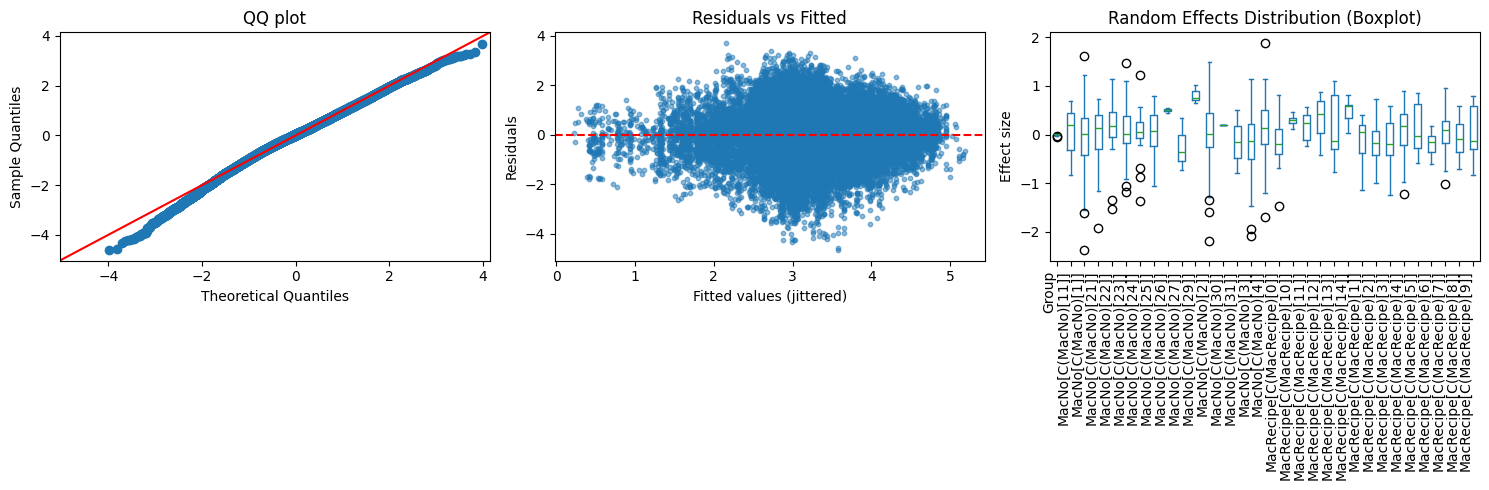

In [71]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

df_filtered = df_filtered.copy() 
target = 'd_PSVarX'
group_for_mixed = 'Part_nbr_grouped'

# 模型公式
formula = """
d_PSVarX ~ plate_layer_2Thick + Residual_Copper_Rate + 
           C(use_cu_type) + C(glass_fabric_type) + C(RC_level) + C(vend_nbr)
"""

vc = {
    "MacNo": "0 + C(MacNo)",
    "MacRecipe": "0 + C(MacRecipe)"
}

# vc = {
#     "MacNo": "0 + C(MacNo)",
#     "Vend": "0 + C(vend_nbr)"
# }

# 拟合混合效應模型
best_mod = smf.mixedlm(
    formula,
    df_filtered,
    groups=df_filtered[group_for_mixed],
    vc_formula=vc,
    re_formula="1"
).fit(method="lbfgs", reml=False)  # lbfgs 比較穩定

print(best_mod.summary())

# AIC、BIC
print("AIC:", best_mod.aic)
print("BIC:", best_mod.bic)

# fitted values
y = df_filtered["d_PSVarX"].values
fitted = best_mod.fittedvalues
resid = y - fitted

# fixed effects (marginal prediction)
fe_params = best_mod.fe_params
X_fe = best_mod.model.exog
y_hat_marg = X_fe @ fe_params

# R²計算
var_y = np.var(y, ddof=1)
R2_marg = 1 - np.var(y - y_hat_marg, ddof=1) / var_y
R2_cond = 1 - np.var(resid, ddof=1) / var_y
print("Marginal R²:", R2_marg)
print("Conditional R²:", R2_cond)
print("variance of random slope:", best_mod.cov_re)        # 隨機截距的方差
print("variance components:", best_mod.vcomp)
# -----------------
# 圖形輸出
# -----------------
fig, axes = plt.subplots(1, 3, figsize=(15,5))

# QQ plot
sm.qqplot(resid, line='45', fit=True, ax=axes[0])
axes[0].set_title("QQ plot")

# 殘差 vs fitted
axes[1].scatter(fitted + np.random.normal(0, 1e-6, size=len(fitted)), resid, alpha=0.5, s=10)
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_xlabel('Fitted values (jittered)')
axes[1].set_ylabel('Residuals')
axes[1].set_title("Residuals vs Fitted")

# 隨機效應分布檢查
random_effects = best_mod.random_effects
re_df = pd.DataFrame(random_effects).T  # 每個 group 的隨機效應
re_df.plot(kind="box", ax=axes[2])
axes[2].set_title("Random Effects Distribution (Boxplot)")
axes[2].set_ylabel("Effect size")
plt.xticks(rotation=90, ha='right')

plt.tight_layout()
plt.show()


In [68]:
resid.var()/y.var()

np.float64(0.6804738467101734)

In [90]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.stats import norm

# # 模擬資料（你可以換成自己的資料 X）
# np.random.seed(123)
# X = np.random.normal(loc=0, scale=1, size=300)  # 測試資料

# # Step 1: 估計參數
# mu_hat = np.mean(X)
# sigma_hat = np.std(X, ddof=1)

# # Step 2: 計算觀察到的 KS 統計量
# X_sorted = np.sort(X)
# edf_true = np.arange(1, len(X)+1) / len(X)
# cdf_true = norm.cdf(X_sorted, loc=mu_hat, scale=sigma_hat)
# D_obs = np.max(np.abs(edf_true - cdf_true))

# # Step 3: Bootstrap
# n_iter = 1000
# D_list = []

# for _ in range(n_iter):
#     # 用估計參數產生資料
#     X_sim = np.random.normal(loc=mu_hat, scale=sigma_hat, size=len(X))

#     # 重新估參數
#     mu_sim = np.mean(X_sim)
#     sigma_sim = np.std(X_sim, ddof=1)

#     # KS 檢定統計量
#     X_sim_sorted = np.sort(X_sim)
#     edf_sim = np.arange(1, len(X_sim)+1) / len(X_sim)
#     cdf_sim = norm.cdf(X_sim_sorted, loc=mu_sim, scale=sigma_sim)
#     Dn = np.max(np.abs(edf_sim - cdf_sim))
    
#     D_list.append(Dn)

# # Step 4: 計算 bootstrap p-value
# p_value = np.mean(np.array(D_list) >= D_obs)
# print(f"Observed D = {D_obs:.4f}")
# print(f"Bootstrapped KS p-value ≈ {p_value:.4f}")

# # Step 5: 畫圖
# plt.hist(D_list, bins=30, density=True, alpha=0.6, label="Bootstrap KS dist")
# plt.axvline(D_obs, color='red', linestyle="--", linewidth=2, label='Observed D')
# plt.title("Bootstrapped KS statistic distribution (Lilliefors approx.)")
# plt.xlabel("KS statistic")
# plt.ylabel("Density")
# plt.legend()
# plt.show()

from scipy.stats import anderson
anderson(resid)

AndersonResult(statistic=np.float64(35.1382123137264), critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(-1.8356538114509353e-14), scale=np.float64(1.0115523013694874))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

In [79]:
within_var = df_filtered.groupby('Part_nbr_grouped')[['mtl_desc2', 'layer_2Thick', 'plate_layer_2Thick', 'Residual_Copper_Rate', 
                'glass_fabric_thickness_mm', 'use_cu_upper_thickness', 'short', 'long', 'use_cu_lower_thickness']].var()
within_var

,mtl_desc2,layer_2Thick,plate_layer_2Thick,Residual_Copper_Rate,glass_fabric_thickness_mm,use_cu_upper_thickness,short,long,use_cu_lower_thickness
Part_nbr_grouped,,,,,,,,,
107S004C78C,0.000048,0.000037,0.000036,0.041470,0.000000,0.011417,0.000000e+00,0.000000e+00,0.011417
107S009A78C,0.000004,0.000001,0.000053,0.024474,0.000020,0.011662,3.014118e-08,2.562033e-08,0.011662
107S013B08C,0.000141,0.000112,0.000026,0.022699,0.000012,0.008293,1.601649e-09,2.836058e-09,0.008293
110EB91C58C,0.000168,0.000112,0.001172,0.029666,0.000000,0.015522,1.992744e-08,2.936683e-09,0.015522
110EC06A68C,0.000055,0.000040,0.000174,0.026926,0.000000,0.004953,2.941182e-09,1.422089e-09,0.004953
...,...,...,...,...,...,...,...,...,...
750Q009B5LG,0.000013,0.000011,0.000096,0.003452,0.000000,0.003925,5.129771e-09,7.164834e-11,0.003925
770Q029I93C,0.000442,0.000450,0.000303,0.035631,0.000457,0.000000,2.330824e-09,1.912569e-09,0.000000
770Q029J93C,0.000442,0.000450,0.000295,0.035624,0.000435,0.000000,5.994952e-09,2.648425e-09,0.000000


In [75]:
def compute_icc(res, verbose=False):
    """
    從 statsmodels MixedLMResults 物件取出 group variance (cov_re) 與 residual variance (scale),
    並計算 ICC = group_var / (group_var + resid_var).
    支援 cov_re 為 DataFrame / ndarray / Series，及 >1 隨機效果的情形 (使用 trace).
    """
    # 1) 取得 cov_re，轉成 ndarray
    cov_re = getattr(res, 'cov_re', None)
    if cov_re is None:
        raise ValueError("res 物件沒有 cov_re 屬性。請確認 res 是 mixedlm 的 fit 結果。")

    # 將可能的 pandas 結構轉為 numpy array
    if isinstance(cov_re, pd.DataFrame) or isinstance(cov_re, pd.Series):
        cov_arr = cov_re.values
    else:
        cov_arr = np.asarray(cov_re)

    # 2) 決定 group variance 的計算方式
    # 若是 1x1，直接取 scalar；否則取 trace（總變異）
    if cov_arr.size == 1:
        group_var = float(cov_arr.ravel()[0])
    else:
        # 若 cov_arr 非方陣，嘗試取方陣部分；一般 cov_re 應為方陣
        if cov_arr.shape[0] != cov_arr.shape[1]:
            if verbose:
                print("警告：cov_re 不是方陣，shape =", cov_arr.shape)
            # 退而求其次：取對角和
            group_var = float(np.diag(cov_arr).sum())
        else:
            group_var = float(np.trace(cov_arr))

    # 3) 取得 residual variance
    resid_var = float(getattr(res, 'scale', np.nan))

    # 4) 數值穩定處理：如果出現負值(理論上不應該)，將其夾到 0
    if np.isnan(group_var) or np.isinf(group_var):
        raise ValueError("group_var 為 NaN 或 infinite，請檢查 fit 結果。")
    if group_var < 0:
        if verbose:
            print(f"注意：group_var = {group_var} < 0，將其設為 0.")
        group_var = 0.0
    if resid_var < 0:
        if verbose:
            print(f"注意：resid_var = {resid_var} < 0，將其設為 0.")
        resid_var = 0.0

    # 5) 計算 ICC（若分母為 0 則回傳 NaN）
    denom = group_var + resid_var
    icc = group_var / denom if denom > 0 else np.nan

    if verbose:
        print("cov_re type:", type(cov_re), "cov_re shape:", getattr(cov_re, 'shape', cov_arr.shape))
        print("group_var:", group_var, "resid_var:", resid_var, "ICC:", icc)

    return group_var, resid_var, icc


gvar_full, rvar_full, icc_full = compute_icc(best_mod, verbose=True)
print("FULL  -> group_var: {:.4f}, resid_var: {:.4f}, ICC: {:.3f}".format(gvar_full, rvar_full, icc_full))


# ICC 就是「隨機效果總變異 / (總變異 + 殘差變異)」

# ICC 越高代表 Part_nbr 之間的差異相對於總變異越大（群間影響大）；ICC 低則群內變異占比高。

# 比較 full vs filtered 的 ICC，可以看出你過濾掉的資料佔了多少 between/within variation（你之前的數字顯示過濾後 both 減小）。


cov_re type: <class 'pandas.core.frame.DataFrame'> cov_re shape: (1, 1)
group_var: 0.024251076760863646 resid_var: 1.0431894190696072 ICC: 0.022718902698174535
cov_re type: <class 'pandas.core.frame.DataFrame'> cov_re shape: (1, 1)
group_var: 0.024251076760863646 resid_var: 1.0431894190696072 ICC: 0.022718902698174535
FULL  -> group_var: 0.0243, resid_var: 1.0432, ICC: 0.023
FILTER-> group_var: 0.0243, resid_var: 1.0432, ICC: 0.023


<p style="font-size: 14px; color: green;">Cov matrix 的cond num、determinant<p>

In [72]:

cov_re = res_filtered_reml.cov_re
print("\nRandom effects covariance matrix:\n", cov_re)
det = np.linalg.det(cov_re)
print("\nDeterminant:", det)
cond_number = np.linalg.cond(cov_re)
print("Condition number:", cond_number)

NameError: name 'res_filtered_reml' is not defined

<p style="font-size: 14px; color: green;">特徵之間的相關性與共線性（VIF）<p>

In [439]:
X = df_filtered[['MacNo','MacRecipe', 'mtl_desc2', 'vend_nbr', 'layer_2Thick', 'plate_mtl_desc1',
                'plate_mtl_desc2', 'plate_vend_nbr', 'plate_layer_2Thick',
                'plate_RC_value', 'Residual_Copper_Rate', 'glass_fabric_thickness_mm',
                'use_cu_upper_thickness', 'use_cu_lower_thickness', 'use_cu_type',
                'glass_fabric_type', 'short', 'bake_result', 'bake_after_browning_result']]

np.linalg.matrix_rank(X), X.shape[1]

(np.int64(19), 19)

In [444]:
df_filtered['layer_2Thick'].unique()

array([ 6.16,  7.36,  6.3 ,  6.5 ,  8.16,  8.7 ,  5.3 ,  5.8 ,  6.56,
        5.96,  4.96,  8.56, 14.3 ,  4.1 ,  7.3 ,  5.1 ,  7.16,  9.56,
       50.56,  4.56,  3.96,  5.16,  7.56, 10.56, 26.16,  6.36, 12.16,
       12.3 ,  7.7 , 19.56,  4.7 , 10.16, 10.3 ,  0.97, 30.16,  8.3 ,
       10.96,  5.66,  0.91,  0.86,  7.5 , 13.16, 13.3 , 25.56, 15.36,
       66.26, 14.56, 14.7 ,  1.05,  1.11,  1.17, 50.16,  5.06,  4.46,
       46.56,  6.86,  6.8 , 17.16, 17.3 ,  8.36, 16.56,  7.  , 12.56,
       28.56, 11.36,  5.56,  5.7 , 27.16, 27.3 , 14.16, 34.96,  9.36,
       13.36,  6.66, 54.46,  8.96,  4.06,  3.46,  4.2 ,  3.6 , 20.16,
       23.16, 10.7 ,  6.96,  0.94, 11.56, 24.96, 18.96, 62.36,  7.26,
        6.06, 14.96, 41.86,  7.86,  0.88,  1.07,  1.62,  0.95,  0.85,
       51.36,  0.92,  1.  , 38.76,  1.01,  7.96, 54.36,  1.06,  0.9 ,
        1.16, 22.56,  1.18,  1.13,  4.16,  1.08, 65.96,  5.5 ,  1.09,
        1.19,  9.7 ,  2.39,  1.1 , 12.34, 13.28, 13.5 ,  6.28,  9.68,
       18.16,  8.5 ,

In [440]:
import patsy
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 建 design matrix for fixed-effects only
formula = """
d_PSVarX ~ layer_2Thick + plate_mtl_desc2 + plate_layer_2Thick + plate_RC_value +
           Residual_Copper_Rate + glass_fabric_thickness_mm + use_cu_upper_thickness + short + use_cu_lower_thickness +
           bake_result + bake_after_browning_result
           """

design_info = smf.mixedlm(formula, df_filtered, groups=df_filtered[group_for_mixed]).fit_regularized(method='l1', alpha=1.0, reml=False).model.data.design_info
X = patsy.build_design_matrices([design_info], df_filtered)[0]
X_df = pd.DataFrame(X, columns = design_info.column_names)

# VIF (略去 intercept if present)
vif_data = pd.DataFrame()
vif_data["feature"] = X_df.columns
vif_data["VIF"] = [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])]
print(vif_data.sort_values('VIF', ascending=False).head(30))


C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1193: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if abs(fe_params[j]) < ceps:
C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1197: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  fe_params[j] = 0.
C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1224: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future versi

                       feature           VIF
0                    Intercept  15500.157644
1                 layer_2Thick      4.941553
6    glass_fabric_thickness_mm      4.650403
7       use_cu_upper_thickness      2.144281
9       use_cu_lower_thickness      2.134361
4               plate_RC_value      1.296012
3           plate_layer_2Thick      1.202102
5         Residual_Copper_Rate      1.143565
11  bake_after_browning_result      1.135166
2              plate_mtl_desc2      1.107289
10                 bake_result      1.017522
8                        short      1.005890


In [435]:
# import pandas as pd
# from patsy import dmatrix
# from sklearn.decomposition import PCA
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# # 1. 用 patsy 根據你的 formula 建立 design matrix（包含所有 dummy）
# design_info = smf.mixedlm(formula, df_filtered, groups=df_filtered[group_for_mixed]).fit_regularized(method='l1', alpha=1.0, reml=False).model.data.design_info
# X = patsy.build_design_matrices([design_info], df_filtered)[0]
# X_df = pd.DataFrame(X, columns=design_info.column_names)

# # 2. 找出哪些欄位是同一組 categorical dummy，例如 prefix 相同
# #    這裡示範以你的 categorical_cols 舉例，匹配 dummy 欄位名稱開頭

# grouped_dummies = {}
# for cat in categorical_cols:
#     grouped_dummies[cat] = [col for col in X_df.columns if col.startswith(f"C({cat})")]

# # 3. 對每組 dummy 用 PCA 取第一主成分，替代該組全部 dummy
# pca_features = []
# for cat, cols in grouped_dummies.items():
#     if len(cols) > 1:
#         pca = PCA(n_components=1)
#         pc1 = pca.fit_transform(X_df[cols])
#         pca_features.append(pd.Series(pc1.flatten(), name=f"PCA_{cat}"))
#     else:
#         # 只有一個dummy，直接用該欄位
#         pca_features.append(X_df[cols[0]])

# # 4. 保留數值變數原始欄位 (不含 categorical dummy 的部分)
# non_cat_cols = [col for col in X_df.columns if all(not col.startswith(f"C({cat})") for cat in categorical_cols)]

# # 5. 合併 PCA 轉換後的特徵和非類別特徵
# X_reduced = pd.concat([X_df[non_cat_cols]] + pca_features, axis=1)

# # 6. 計算 VIF
# vif_data = pd.DataFrame()
# vif_data["feature"] = X_reduced.columns
# vif_data["VIF"] = [variance_inflation_factor(X_reduced.values, i) for i in range(X_reduced.shape[1])]

# print(vif_data.sort_values('VIF', ascending=False))


In [ ]:
# explained_var_ratio = pca.explained_variance_ratio_[0]
# print(f"PC1 explained variance ratio: {explained_var_ratio:.4f}")

In [ ]:
# # requirements:
# # pip install scikit-learn statsmodels pandas numpy patsy

# import numpy as np
# import pandas as pd
# from sklearn.preprocessing import OneHotEncoder, StandardScaler
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.linear_model import LassoCV, Lasso
# from sklearn.model_selection import KFold
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# import patsy
# import warnings

# warnings.filterwarnings("ignore")

# # ------------------------
# # 1) 建構設計矩陣函式
# # ------------------------
# def build_design_matrix(df, numeric_cols, categorical_cols, drop_first=True, handle_unknown='ignore'):
#     """
#     回傳 X (ndarray) 與 X_df (DataFrame with column names)
#     - numeric_cols: list of numeric column names
#     - categorical_cols: list of categorical column names
#     - drop_first: whether to drop first dummy to avoid perfect multicollinearity
#     """
#     # ColumnTransformer with OneHotEncoder for categoricals
#     ohe = OneHotEncoder(drop='first' if drop_first else None,
#                         sparse_output=False, handle_unknown=handle_unknown)
#     transformers = []
#     if categorical_cols:
#         transformers.append(('cat', ohe, categorical_cols))
#     if numeric_cols:
#         transformers.append(('num', 'passthrough', numeric_cols))
#     ct = ColumnTransformer(transformers, remainder='drop', sparse_threshold=0)
#     X_arr = ct.fit_transform(df)

#     # build column names
#     col_names = []
#     if categorical_cols:
#         cat_names = ct.named_transformers_['cat'].get_feature_names_out(categorical_cols)
#         col_names.extend(list(cat_names))
#     if numeric_cols:
#         col_names.extend(numeric_cols)

#     X_df = pd.DataFrame(X_arr, columns=col_names, index=df.index)
#     return X_arr, X_df, ct

# # ------------------------
# # 2) 條件數（condition number）
# # ------------------------
# def condition_number(X, scaled=True):
#     """
#     計算 condition number = s_max / s_min (SVD singular values)
#     若 scaled=True, 會先把 X 每 column 做標準化 (zero mean, unit var)
#     """
#     Xc = np.array(X, dtype=float)
#     if scaled:
#         Xc = (Xc - np.nanmean(Xc, axis=0)) / (np.nanstd(Xc, axis=0) + 1e-12)
#     # SVD
#     s = np.linalg.svd(Xc, compute_uv=False)
#     # guard small singular values
#     cond = float(s[0] / (s[-1] + 1e-20))
#     return cond, s

# # ------------------------
# # 3) VIF 計算（只建議對數值或有限數量的 dummy）
# # ------------------------
# def compute_vif(X_df):
#     """
#     計算 VIF for each column in X_df. X_df should be a pandas DataFrame.
#     Warning: VIF for many dummies may be noisy.
#     """
#     X = X_df.copy().astype(float)
#     # add const to avoid singular design for VIF calc
#     X['__const__'] = 1.0
#     vif_vals = []
#     cols = X.columns.tolist()
#     for i, col in enumerate(cols[:-1]):  # skip const at the end
#         try:
#             vif = variance_inflation_factor(X.values, i)
#         except Exception:
#             vif = np.nan
#         vif_vals.append((col, vif))
#     return pd.DataFrame(vif_vals, columns=['feature', 'VIF']).sort_values('VIF', ascending=False)

# # ------------------------
# # 4) LassoCV pipeline fitting
# # ------------------------
# def fit_lasso_cv(X_df, y, n_alphas=100, cv=5, random_state=42):
#     """
#     Fit LassoCV and standardize features. Return fitted pipeline and report sparsity.
#     """
#     scaler = StandardScaler()
#     lasso_cv = LassoCV(cv=cv, n_alphas=n_alphas, random_state=random_state, max_iter=2000)
#     # Standardize X first
#     Xs = scaler.fit_transform(X_df.values)
#     lasso_cv.fit(Xs, y.values)
#     alpha_opt = lasso_cv.alpha_
#     coef = lasso_cv.coef_
#     nonzero_idx = np.nonzero(coef)[0]
#     nonzero_features = X_df.columns[nonzero_idx].tolist()
#     sparsity = 1.0 - (len(nonzero_idx) / X_df.shape[1])
#     report = {
#         'alpha_opt': alpha_opt,
#         'n_features': X_df.shape[1],
#         'n_nonzero': len(nonzero_idx),
#         'sparsity': sparsity,
#         'nonzero_features': nonzero_features,
#         'coef': pd.Series(coef, index=X_df.columns)
#     }
#     return lasso_cv, scaler, report

# # ------------------------
# # 5) Lasso 穩定性選擇 (bootstrap frequency)
# # ------------------------
# def lasso_stability_selection(X_df, y, n_boot=100, sample_frac=0.75, alpha=None, cv=3, random_state=0):
#     """
#     Repeated Lasso fits on bootstrap samples: return selection frequency for each feature.
#     If alpha is None, use LassoCV on each bootstrap sample; otherwise use fixed alpha.
#     """
#     rng = np.random.RandomState(random_state)
#     n = X_df.shape[0]
#     sel_counts = np.zeros(X_df.shape[1], dtype=int)
#     for i in range(n_boot):
#         idx = rng.choice(n, size=int(sample_frac * n), replace=True)
#         Xs = X_df.values[idx]
#         ys = y.values[idx]
#         scaler = StandardScaler()
#         Xs = scaler.fit_transform(Xs)
#         if alpha is None:
#             model = LassoCV(cv=cv, random_state=rng.randint(1e6), max_iter=2000).fit(Xs, ys)
#             alpha_i = model.alpha_
#             lasso = Lasso(alpha=alpha_i, max_iter=2000).fit(Xs, ys)
#         else:
#             lasso = Lasso(alpha=alpha, max_iter=2000).fit(Xs, ys)
#         sel_counts += (np.abs(lasso.coef_) > 1e-8).astype(int)
#     freq = sel_counts / float(n_boot)
#     return pd.Series(freq, index=X_df.columns).sort_values(ascending=False)

# # ------------------------
# # 6) 一個整合流程函式
# # ------------------------
# def collinearity_l1_diagnostics(df, target, numeric_cols, categorical_cols,
#                                  do_vif=True, vif_limit_report=30, lasso_cv=True,
#                                  stability_boot=100):
#     """
#     一鍵執行：建立設計矩陣、計算 condition number、(可選)VIF、LassoCV、以及穩定性測試
#     回傳一個 dict 包含結果與 dataframe summary
#     """
#     # build design matrix
#     X_arr, X_df, ct = build_design_matrix(df, numeric_cols, categorical_cols, drop_first=True)
#     # drop columns with zero variance
#     nz_mask = (X_df.std(axis=0) > 1e-12)
#     if not nz_mask.all():
#         X_df = X_df.loc[:, nz_mask]

#     # compute condition number
#     cond, svals = condition_number(X_df.values, scaled=True)

#     out = {'X_df': X_df, 'condition_number': cond, 'singular_values': svals}

#     # optionally compute VIF (warning: expensive for many cols)
#     if do_vif:
#         # if too many columns, skip or apply to top-k numeric/dummy
#         if X_df.shape[1] > 300:
#             out['vif'] = None
#             out['vif_note'] = f"Too many features ({X_df.shape[1]}), skip full VIF. Consider subset VIF on numeric or top-k dummies."
#         else:
#             out['vif'] = compute_vif(X_df)
#     # LassoCV fit
#     if lasso_cv:
#         y = df[target]
#         lasso_model, scaler, lasso_report = fit_lasso_cv(X_df, y, cv=5)
#         out['lasso_report'] = lasso_report
#         # model performance on full data (just for quick check)
#         Xs_full = scaler.transform(X_df.values)
#         out['lasso_r2'] = lasso_model.score(Xs_full, y.values)
#     # stability selection
#     if stability_boot and lasso_cv:
#         alpha_use = out['lasso_report']['alpha_opt']
#         freq = lasso_stability_selection(X_df, df[target], n_boot=stability_boot, alpha=alpha_use)
#         out['selection_freq'] = freq
#     return out

In [ ]:
df.columns

In [ ]:
# ------------------------
# Example usage:
# ------------------------
# 假設 df 是你的 dataframe, target 為 'd_PSVarX'
# numeric_cols = ['mtl_desc2', 'layer_2Thick', 'plate_mtl_desc2', 'plate_layer_2Thick', 'plate_RC_value', 'Residual_Copper_Rate', 
#                 'glass_fabric_thickness_mm', 'use_cu_upper_thickness', 'use_cu_lower_thickness', 'short']
numeric_cols = [ 'layer_2Thick', 'plate_mtl_desc2', 'plate_layer_2Thick', 'plate_RC_value', 'Residual_Copper_Rate', 
                 'glass_fabric_thickness_mm', 'use_cu_upper_thickness', 'use_cu_lower_thickness', 'short']

categorical_cols = ['use_cu_type', 'glass_fabric_type', 'vend_nbr', 'MacRecipe', 'MacNo']
res = collinearity_l1_diagnostics(df_filtered, target='d_PSVarX', numeric_cols=numeric_cols, categorical_cols = [],
                                  do_vif=False, lasso_cv=True, stability_boot=100)

# then:
print("Condition number:", res['condition_number'])
print("Lasso alpha", res['lasso_report']['alpha_opt'])
print("Nonzero features:", res['lasso_report']['n_nonzero'])
print("Top selection freq:\n", res['selection_freq'].head(30))


In [ ]:
# def weighted_mean_encoding(df, cat_col, target, weight_col=None):
#     if weight_col is None:
#         # 權重為1（等權）
#         weight_col = '__w__'
#         df[weight_col] = 1

#     weighted_means = (
#         df.groupby(cat_col)
#           .apply(lambda g: (g[target] * g[weight_col]).sum() / g[weight_col].sum())
#           .to_dict()
#     )

#     return df[cat_col].map(weighted_means)

# # 建立新 DataFrame 做 encoding
# df_encoded = df_filtered.copy()

# # 用加權平均編碼 categorical_cols
# for col in categorical_cols:
#     df_encoded[col] = weighted_mean_encoding(
#         df_encoded, 
#         cat_col=col, 
#         target='d_PSVarX', 
#         weight_col=None  # 如果有特定權重欄位可以換掉
#     )

# # 再跑 collinearity_l1_diagnostics
# numeric_cols_extended = numeric_cols + categorical_cols  # 因為編碼後都是數字
# res = collinearity_l1_diagnostics(
#     df_encoded, 
#     target='d_PSVarX', 
#     numeric_cols=numeric_cols_extended, 
#     categorical_cols=[],  # 已經轉成數值
#     do_vif=False, 
#     lasso_cv=True, 
#     stability_boot=100
# )

# print("Condition number:", res['condition_number'])
# print("Lasso alpha", res['lasso_report']['alpha_opt'])
# print("Nonzero features:", res['lasso_report']['n_nonzero'])
# print("Top selection freq:\n", res['selection_freq'].head(30))


<p style="font-size: 14px; color: green;">找出對殘差貢獻最大的 Part_nbr / Lot_nbr<p>

<p style="font-size: 16px; color: blue;">XGB<p>

In [72]:
df_filtered = df_filtered.copy()
group_counts = df_filtered.groupby('Part_nbr_grouped')['d_PSVarX'].transform('count')
df_filtered['sample_weight'] = 1 / group_counts
df_filtered['sample_weight'] *= len(df_filtered) / df_filtered['sample_weight'].sum()

In [138]:
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

target = 'd_PSVarX'
group_col = 'Part_nbr_grouped'
weight_col = 'sample_weight'

num_features = ["plate_layer_2Thick","Residual_Copper_Rate","glass_fabric_thickness_mm","use_cu_upper_thickness","short","use_cu_lower_thickness"]
cat_features = [ "mtl_desc2","use_cu_type","glass_fabric_type","RC_level","MacRecipe"]

X = df_filtered[num_features + cat_features]
y = df_filtered[target].values
groups = df_filtered[group_col].values
sample_weight = df_filtered[weight_col].values if weight_col in df_filtered else None

preprocessor = ColumnTransformer(transformers=[('num', 'passthrough', num_features),
                                               ('cat', 'passthrough', cat_features)
                                               # ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
                                              ])

rf_model = RandomForestRegressor(n_estimators=50, max_depth=10, min_samples_split=5, min_samples_leaf=3, bootstrap=False, random_state=123)
rf_model.fit(X,y)

pipeline = Pipeline(steps=[('preprocess', preprocessor), ('model', rf_model)])

gkf = GroupKFold(n_splits=5)

scores = []
for train_idx, test_idx in gkf.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    w_train = sample_weight[train_idx] if sample_weight is not None else None
    w_test = sample_weight[test_idx] if sample_weight is not None else None

    pipeline.fit(X_train, y_train, model__sample_weight=w_train)
    r2 = pipeline.score(X_test, y_test)
    scores.append(r2)
    print(f'R2 = {r2:.4f}')
print(f'Mean R2 = ', np.mean(scores))

R2 = -0.1610
R2 = -0.8606
R2 = -0.2984
R2 = -0.3475
R2 = -0.2162
Mean R2 =  -0.3767461241114661


In [139]:
rf_model.feature_importances_, X_train.columns

(array([0.16510159, 0.07808554, 0.07023284, 0.02230069, 0.13161539,
        0.01006152, 0.05646226, 0.08998809, 0.08278596, 0.02087961,
        0.27248652]),
 Index(['plate_layer_2Thick', 'Residual_Copper_Rate',
        'glass_fabric_thickness_mm', 'use_cu_upper_thickness', 'short',
        'use_cu_lower_thickness', 'mtl_desc2', 'use_cu_type',
        'glass_fabric_type', 'RC_level', 'MacRecipe'],
       dtype='object'))

In [144]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_classification

rf_reg_mod = RandomForestRegressor(n_estimators=50, max_depth=10, min_samples_split=5, min_samples_leaf=3) #解包字典
rf_reg_mod.fit(X, y)

print('R_square: ',rf_reg_mod.score(X, y))


rf_feature_importances = rf_reg_mod.feature_importances_

feature_importances_df = pd.DataFrame({'features': X.columns,
                                      'feature_importances':rf_feature_importances
                                     })

feature_importances_df = feature_importances_df.sort_values(by = 'feature_importances', ascending = False).reset_index(drop=True)
feature_importances_df

R_square:  0.2392529049166482


,features,feature_importances
0,MacRecipe,0.249179
1,plate_layer_2Thick,0.151331
2,short,0.147939
3,Residual_Copper_Rate,0.122288
4,glass_fabric_type,0.090626
5,use_cu_type,0.074392
6,glass_fabric_thickness_mm,0.071672
7,mtl_desc2,0.043554
8,RC_level,0.021813
9,use_cu_lower_thickness,0.015819


In [147]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf_reg_mod, X, y, cv=5, scoring='r2')
# gkf = GroupKFold(n_splits=5)
# scores_group = cross_val_score(rf_reg_mod, X, y, cv=gkf, groups=X['MacRecipe'], scoring="r2")
print("CV R² mean:", np.mean(scores), "std:", np.std(scores))

CV R² mean: -0.05601001852797598 std: 0.0247782042479601


In [148]:
from sklearn.dummy import DummyRegressor

dummy = DummyRegressor(strategy="mean")
scores_dummy = cross_val_score(dummy, X, y, cv=5, scoring="r2")
print("Dummy CV R²:", scores_dummy.mean())


Dummy CV R²: -0.006581138836661981


In [151]:
df_filtered.columns

Index(['Part_nbr', 'Lot_nbr', 'Layer', 'd_Layer', 'AVGX', 'AVGY', 'MacNo',
       'MacRecipe', 'mtl_desc2', 'mtl_desc4', 'vend_nbr', 'layer_2Thick',
       'plate_mtl_desc1', 'plate_mtl_desc2', 'plate_vend_nbr',
       'plate_layer_2Thick', 'plate_RC_value', 'Residual_Copper_Rate',
       'glass_fabric_thickness_mm', 'use_cu_upper_thickness',
       'use_cu_lower_thickness', 'use_cu_type', 'glass_fabric_type', 'short',
       'long', 'bake_result', 'bake_measured', 'bake_after_browning_result',
       'bake_after_browning_measured', 'd_PSVarX', 'd_PSVarY',
       'Part_nbr_grouped', '_batch_key', 'batch_is_normal', 'layer_2Thick_nan',
       'plate_layer_2Thick_nan', 'glass_fabric_thickness_mm_nan',
       'use_cu_upper_thickness_nan', 'use_cu_lower_thickness_nan', 'short_nan',
       'long_nan', 'RC_level'],
      dtype='object')

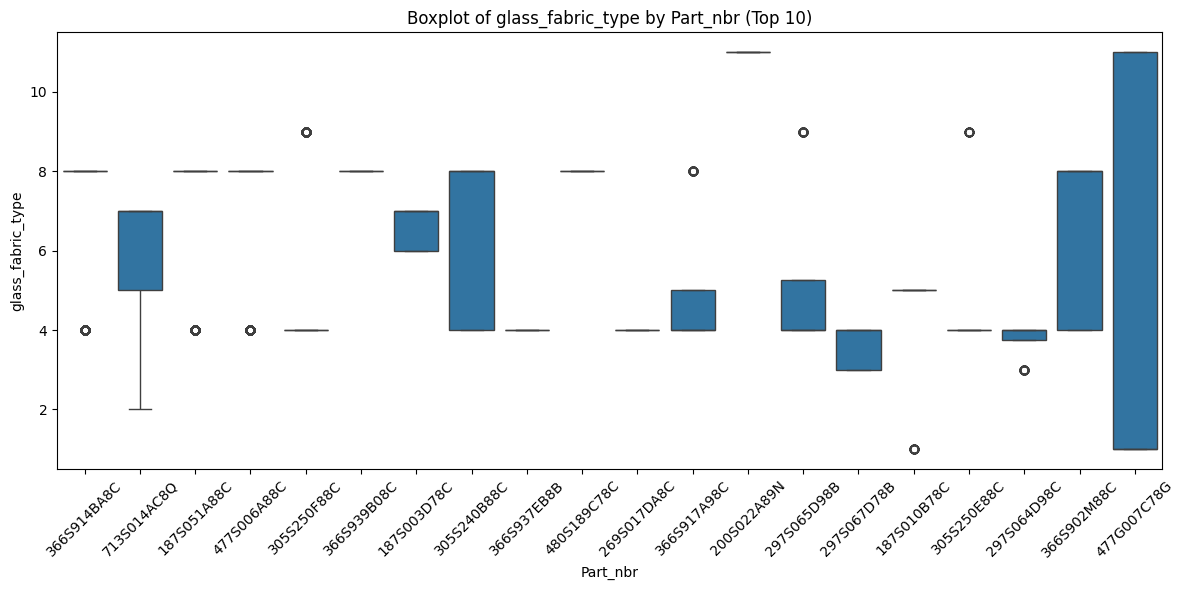

In [155]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 假設 df 裡有 'Part_nbr' 和你要分析的特徵，例如 'Residual_Copper_Rate'
feature = "glass_fabric_type"

# 取出前10個料號 (出現次數最多的前10個)
top_parts = df_filtered["Part_nbr"].value_counts().index[:20]
df_top = df_filtered[df_filtered["Part_nbr"].isin(top_parts)]

plt.figure(figsize=(12,6))
sns.boxplot(x="Part_nbr", y=feature, data=df_top, order=top_parts)

plt.title(f"Boxplot of {feature} by Part_nbr (Top 10)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [156]:
df_filtered.columns

Index(['Part_nbr', 'Lot_nbr', 'Layer', 'd_Layer', 'AVGX', 'AVGY', 'MacNo',
       'MacRecipe', 'mtl_desc2', 'mtl_desc4', 'vend_nbr', 'layer_2Thick',
       'plate_mtl_desc1', 'plate_mtl_desc2', 'plate_vend_nbr',
       'plate_layer_2Thick', 'plate_RC_value', 'Residual_Copper_Rate',
       'glass_fabric_thickness_mm', 'use_cu_upper_thickness',
       'use_cu_lower_thickness', 'use_cu_type', 'glass_fabric_type', 'short',
       'long', 'bake_result', 'bake_measured', 'bake_after_browning_result',
       'bake_after_browning_measured', 'd_PSVarX', 'd_PSVarY',
       'Part_nbr_grouped', '_batch_key', 'batch_is_normal', 'layer_2Thick_nan',
       'plate_layer_2Thick_nan', 'glass_fabric_thickness_mm_nan',
       'use_cu_upper_thickness_nan', 'use_cu_lower_thickness_nan', 'short_nan',
       'long_nan', 'RC_level'],
      dtype='object')

In [165]:
x = df_filtered['mtl_desc2']
y = df_filtered['Residual_Copper_Rate']
x.corr(y)

np.float64(0.1261620903404928)